In [681]:
from IPython.display import HTML
HTML('''
    <style> body {font-family: "Roboto Condensed Light", "Roboto Condensed";} h2 {padding: 10px 12px; background-color: #E64626; position: static; color: #ffffff; font-size: 40px;} .text_cell_render p { font-size: 15px; } .text_cell_render h1 { font-size: 30px; } h1 {padding: 10px 12px; background-color: #E64626; color: #ffffff; font-size: 40px;} .text_cell_render h3 { padding: 10px 12px; background-color: #0148A4; position: static; color: #ffffff; font-size: 20px;} h4:before{ 
    content: "@"; font-family:"Wingdings"; font-style:regular; margin-right: 4px;} .text_cell_render h4 {padding: 8px; font-family: "Roboto Condensed Light"; position: static; font-style: italic; background-color: #FFB800; color: #ffffff; font-size: 18px; text-align: center; border-radius: 5px;}input[type=submit] {background-color: #E64626; border: solid; border-color: #734036; color: white; padding: 8px 16px; text-decoration: none; margin: 4px 2px; cursor: pointer; border-radius: 20px;}</style>
    <script> code_show=true; function code_toggle() {if (code_show){$('div.input').hide();} else {$('div.input').show();} code_show = !code_show} $( document ).ready(code_toggle);</script>
    <form action="javascript:code_toggle()"><input type="submit" value="Hide/show all code."></form>
''')

# Sydney Liveability Analysis

## Assignment Group F12D-RE08 - 10

### Dawei Yun
### Zirong Wen

## Import 

In [28]:
from __future__ import (absolute_import, division, print_function)
import os
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, MultiPolygon
import pandas as pd
import geopandas as gpd 
from geopandas import GeoSeries, GeoDataFrame
from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import *
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import numpy as np
import csv
import pprint

## Connect to  Database

In [29]:
credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        try:
            db = create_engine('postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db, echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

db, conn = pgconnect(credentials)

Connected successfully.


## Define query 

In [30]:
def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(sqlcmd, args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

## 1. Clean dataset and Create Databases

### 1.1 Neighbourhoods

#### 1.1.1 Define Clean Function, convert null value to "null"

In [81]:
DEFAULT = "null"

def clean(data, column, datatype, null):
    for i,row in data.iterrows():
        old_value = row[column]
        new_value = null
        try:
            new_value = datatype(old_value)
        except (ValueError, TypeError):
            print('Replacing{} with {} in column {}'.format(row[column], new_value, column))
        row[column] = new_value

#### 1.1.2 Remove the thousands separator and create young column representing ages 0 to 19

In [655]:
neighbourhoods = pd.read_csv('Neighbourhoods.csv',thousands=',')
neighbourhoods.rename(columns = {'0-4':'one','5-9':'two','10-14':'three','15-19':'four'},inplace=True)
neighbourhoods['young'] = neighbourhoods['one']+neighbourhoods['two']+neighbourhoods['three']+neighbourhoods['four']
neighbourhoods

,Unnamed: 0,area_id,area_name,land_area,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent,one,two,three,four,young
0,0,102011028,Avoca Beach - Copacabana,643.8000,7590.0,2325,738.0,46996.0,1906.0,467,583,604,560,2214
1,1,102011029,Box Head - MacMasters Beach,3208.6000,10986.0,3847,907.0,42621.0,1682.0,586,696,661,692,2635
2,2,102011030,Calga - Kulnura,76795.1000,4841.0,1575,1102.0,42105.0,1182.0,220,254,304,320,1098
3,3,102011031,Erina - Green Point,3379.3000,14237.0,4450,1666.0,43481.0,1595.0,695,778,916,838,3227
4,4,102011032,Gosford - Springfield,1691.2000,19385.0,6373,2126.0,45972.0,1382.0,1200,1079,963,977,4219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,317,106011109,Cessnock Region,1570.4341,7931.0,3281,673.0,73164.0,1080.0,432,590,577,527,2126
318,318,106011113,Singleton Region,4067.2349,4919.0,2055,698.0,87984.0,1000.0,310,394,353,323,1380
319,319,111021218,Morisset - Cooranbong,330.5208,14959.0,6298,1154.0,58084.0,1260.0,813,855,828,962,3458
320,320,114021285,Hill Top - Colo Vale,174.3752,6025.0,2249,400.0,81120.0,1512.0,443,500,470,451,1864


#### 1.1.3 Drop the column we don't need

In [656]:
neighbourhoods.drop('number_of_businesses', axis=1, inplace=True)
neighbourhoods.drop('number_of_dwellings', axis=1, inplace=True)
neighbourhoods.drop('one', axis=1, inplace=True)
neighbourhoods.drop('two', axis=1, inplace=True)
neighbourhoods.drop('three', axis=1, inplace=True)
neighbourhoods.drop('four', axis=1, inplace=True)
neighbourhoods.drop('Unnamed: 0', axis=1, inplace=True)
neighbourhoods

,area_id,area_name,land_area,population,median_annual_household_income,avg_monthly_rent,young
0,102011028,Avoca Beach - Copacabana,643.8000,7590.0,46996.0,1906.0,2214
1,102011029,Box Head - MacMasters Beach,3208.6000,10986.0,42621.0,1682.0,2635
2,102011030,Calga - Kulnura,76795.1000,4841.0,42105.0,1182.0,1098
3,102011031,Erina - Green Point,3379.3000,14237.0,43481.0,1595.0,3227
4,102011032,Gosford - Springfield,1691.2000,19385.0,45972.0,1382.0,4219
...,...,...,...,...,...,...,...
317,106011109,Cessnock Region,1570.4341,7931.0,73164.0,1080.0,2126
318,106011113,Singleton Region,4067.2349,4919.0,87984.0,1000.0,1380
319,111021218,Morisset - Cooranbong,330.5208,14959.0,58084.0,1260.0,3458
320,114021285,Hill Top - Colo Vale,174.3752,6025.0,81120.0,1512.0,1864


#### 1.1.4 Convert the null value to "null"

In [657]:
clean(neighbourhoods, "land_area", float, DEFAULT)
clean(neighbourhoods, "population", int, DEFAULT)
clean(neighbourhoods, "median_annual_household_income", float, DEFAULT)
clean(neighbourhoods, "avg_monthly_rent", float, DEFAULT)
clean(neighbourhoods, "young", int, DEFAULT)
neighbourhoods

Replacingnan with null in column population


,area_id,area_name,land_area,population,median_annual_household_income,avg_monthly_rent,young
0,102011028,Avoca Beach - Copacabana,643.8000,7590.0,46996.0,1906.0,2214
1,102011029,Box Head - MacMasters Beach,3208.6000,10986.0,42621.0,1682.0,2635
2,102011030,Calga - Kulnura,76795.1000,4841.0,42105.0,1182.0,1098
3,102011031,Erina - Green Point,3379.3000,14237.0,43481.0,1595.0,3227
4,102011032,Gosford - Springfield,1691.2000,19385.0,45972.0,1382.0,4219
...,...,...,...,...,...,...,...
317,106011109,Cessnock Region,1570.4341,7931.0,73164.0,1080.0,2126
318,106011113,Singleton Region,4067.2349,4919.0,87984.0,1000.0,1380
319,111021218,Morisset - Cooranbong,330.5208,14959.0,58084.0,1260.0,3458
320,114021285,Hill Top - Colo Vale,174.3752,6025.0,81120.0,1512.0,1864


#### 1.1.5 Create table neighbourhoods and upload the cleaned data to the database

In [658]:
conn.execute("""
DROP TABLE IF EXISTS neighbourhoods;
CREATE TABLE neighbourhoods (
    area_id INTEGER NOT NULL PRIMARY KEY, 
    area_name VARCHAR(50), 
    land_area FLOAT,
    population INTEGER,
    median_annual_household_income INTEGER,
    avg_monthly_rent INTEGER,
    young INTEGER
);"""
)

neighbourhoods.to_sql('neighbourhoods', conn, if_exists='append', index=False)
query(conn, "select * from neighbourhoods")

,area_id,area_name,land_area,population,median_annual_household_income,avg_monthly_rent,young
0,102011028,Avoca Beach - Copacabana,643.8000,7590.0,46996.0,1906.0,2214
1,102011029,Box Head - MacMasters Beach,3208.6000,10986.0,42621.0,1682.0,2635
2,102011030,Calga - Kulnura,76795.1000,4841.0,42105.0,1182.0,1098
3,102011031,Erina - Green Point,3379.3000,14237.0,43481.0,1595.0,3227
4,102011032,Gosford - Springfield,1691.2000,19385.0,45972.0,1382.0,4219
...,...,...,...,...,...,...,...
317,106011109,Cessnock Region,1570.4341,7931.0,73164.0,1080.0,2126
318,106011113,Singleton Region,4067.2349,4919.0,87984.0,1000.0,1380
319,111021218,Morisset - Cooranbong,330.5208,14959.0,58084.0,1260.0,3458
320,114021285,Hill Top - Colo Vale,174.3752,6025.0,81120.0,1512.0,1864


### 1.2 BusinessStats

#### 1.2.1 Drop the column we don't need, drop the outliers.

In [652]:
business = pd.read_csv('BusinessStats.csv',thousands=',')
business.drop('number_of_businesses', axis=1, inplace=True)
business

,area_id,area_name,accommodation_and_food_services,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing
0,101021007,Braidwood,26,27,280,11,0,35
1,101021008,Karabar,7,10,8,11,0,43
2,101021009,Queanbeyan,52,47,11,56,3,77
3,101021010,Queanbeyan - East,16,23,4,12,0,57
4,101021011,Queanbeyan Region,39,63,292,34,7,81
...,...,...,...,...,...,...,...,...
2296,901011001,Christmas Island,0,0,0,0,0,0
2297,901021002,Cocos (Keeling) Islands,3,0,0,0,0,0
2298,901031003,Jervis Bay,0,3,0,0,0,0
2299,901041004,Norfolk Island,0,0,0,0,0,0


#### 1.2.2 Use clean function clean the file

In [653]:
clean(business, "area_id", int, DEFAULT)
clean(business, "accommodation_and_food_services", int, DEFAULT)
clean(business, "retail_trade", int, DEFAULT)
clean(business, "agriculture_forestry_and_fishing", int, DEFAULT)
clean(business, "health_care_and_social_assistance", int, DEFAULT)
clean(business, "public_administration_and_safety", int, DEFAULT)
clean(business, "transport_postal_and_warehousing", int, DEFAULT)
business

,area_id,area_name,accommodation_and_food_services,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing
0,101021007,Braidwood,26,27,280,11,0,35
1,101021008,Karabar,7,10,8,11,0,43
2,101021009,Queanbeyan,52,47,11,56,3,77
3,101021010,Queanbeyan - East,16,23,4,12,0,57
4,101021011,Queanbeyan Region,39,63,292,34,7,81
...,...,...,...,...,...,...,...,...
2296,901011001,Christmas Island,0,0,0,0,0,0
2297,901021002,Cocos (Keeling) Islands,3,0,0,0,0,0
2298,901031003,Jervis Bay,0,3,0,0,0,0
2299,901041004,Norfolk Island,0,0,0,0,0,0


#### 1.2.3 Create a new table business and upload the cleaned data to the database

In [654]:
conn.execute("""
DROP TABLE IF EXISTS business;
CREATE TABLE business (
    "area_id" INTEGER, 
    "area_name" VARCHAR(50), 
    "accommodation_and_food_services" INTEGER,
    "retail_trade" INTEGER,
    "agriculture_forestry_and_fishing" INTEGER,
    "health_care_and_social_assistance" INTEGER,
    "public_administration_and_safety" INTEGER,
    "transport_postal_and_warehousing" INTEGER
);"""
)

business.to_sql('business', conn, if_exists='append', index=False)
query(conn, "select * from business")

,area_id,area_name,accommodation_and_food_services,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing
0,101021007,Braidwood,26,27,280,11,0,35
1,101021008,Karabar,7,10,8,11,0,43
2,101021009,Queanbeyan,52,47,11,56,3,77
3,101021010,Queanbeyan - East,16,23,4,12,0,57
4,101021011,Queanbeyan Region,39,63,292,34,7,81
...,...,...,...,...,...,...,...,...
2296,901011001,Christmas Island,0,0,0,0,0,0
2297,901021002,Cocos (Keeling) Islands,3,0,0,0,0,0
2298,901031003,Jervis Bay,0,3,0,0,0,0
2299,901041004,Norfolk Island,0,0,0,0,0,0


## Define function for cleaning shapefiles, convert polygon to multpolygon

In [392]:
def clean_geom (geom,srid):
    if (geom.geom_type == 'Polygon'):
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

### 1.3 SA2_2016_AUST

In [393]:
sa = gpd.read_file("sa2/SA2_2016_AUST.shp")

#### 1.3.1 Drop the column we don't need

In [394]:
sa.drop('STE_NAME16', axis=1, inplace=True)
sa.drop('STE_CODE16', axis=1, inplace=True)
sa.drop('GCC_CODE16', axis=1, inplace=True)
sa.drop('SA4_CODE16', axis=1, inplace=True)
sa.drop('SA3_CODE16', axis=1, inplace=True)
sa.drop('SA2_5DIG16', axis=1, inplace=True)
sa

,SA2_MAIN16,SA2_NAME16,SA3_NAME16,SA4_NAME16,GCC_NAME16,AREASQKM16,geometry
0,101021007,Braidwood,Queanbeyan,Capital Region,Rest of NSW,3418.3525,"POLYGON ((149.58423 -35.44427, 149.58444 -35.4..."
1,101021008,Karabar,Queanbeyan,Capital Region,Rest of NSW,6.9825,"POLYGON ((149.21898 -35.36739, 149.21799 -35.3..."
2,101021009,Queanbeyan,Queanbeyan,Capital Region,Rest of NSW,4.7634,"POLYGON ((149.21325 -35.34325, 149.21619 -35.3..."
3,101021010,Queanbeyan - East,Queanbeyan,Capital Region,Rest of NSW,13.0034,"POLYGON ((149.24033 -35.34782, 149.24023 -35.3..."
4,101021011,Queanbeyan Region,Queanbeyan,Capital Region,Rest of NSW,3054.4099,"POLYGON ((149.23580 -35.38738, 149.23771 -35.3..."
...,...,...,...,...,...,...,...
2305,901021002,Cocos (Keeling) Islands,Cocos (Keeling) Islands,Other Territories,Other Territories,13.7163,"MULTIPOLYGON (((96.83047 -12.17636, 96.83045 -..."
2306,901031003,Jervis Bay,Jervis Bay,Other Territories,Other Territories,67.8134,"MULTIPOLYGON (((150.69566 -35.18297, 150.69555..."
2307,901041004,Norfolk Island,Norfolk Island,Other Territories,Other Territories,38.6509,"MULTIPOLYGON (((167.99472 -29.04534, 167.99432..."
2308,997979799,Migratory - Offshore - Shipping (OT),Migratory - Offshore - Shipping (OT),Migratory - Offshore - Shipping (OT),Migratory - Offshore - Shipping (OT),0.0000,None


 #### 1.3.2 Check the EPSG code for SA2 file

In [395]:
sa.crs 

<Geographic 2D CRS: EPSG:4283>
Name: GDA94
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Australia - GDA
- bounds: (93.41, -60.56, 173.35, -8.47)
Datum: Geocentric Datum of Australia 1994
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

#### 1.3.3 Check the geometry type

In [396]:
sa.geom_type.unique()

array(['Polygon', 'MultiPolygon', None], dtype=object)

#### 1.3.4 Delete the row with NA or None value

In [397]:
sa = sa.replace(to_replace='None', value=np.nan).dropna()

#### 1.3.5 Check the cleaned geometry type

In [398]:
sa.geom_type.unique()

array(['Polygon', 'MultiPolygon'], dtype=object)

#### 1.3.6 Change the Polygon to MultPolygon

In [399]:
srid = 4283
sa['geom'] = sa['geometry'].apply(lambda x: clean_geom(geom=x, srid=srid))
sa = sa.drop(columns="geometry")

In [400]:
sa.rename(columns={
    'geom': 'geometry'
}, inplace=True)
sa.head()

,SA2_MAIN16,SA2_NAME16,SA3_NAME16,SA4_NAME16,GCC_NAME16,AREASQKM16,geometry
0,101021007,Braidwood,Queanbeyan,Capital Region,Rest of NSW,3418.3525,MULTIPOLYGON (((149.5842329970001 -35.44426999...
1,101021008,Karabar,Queanbeyan,Capital Region,Rest of NSW,6.9825,MULTIPOLYGON (((149.2189819130001 -35.36739402...
2,101021009,Queanbeyan,Queanbeyan,Capital Region,Rest of NSW,4.7634,MULTIPOLYGON (((149.2132479820001 -35.34324799...
3,101021010,Queanbeyan - East,Queanbeyan,Capital Region,Rest of NSW,13.0034,MULTIPOLYGON (((149.240332114 -35.347822616999...
4,101021011,Queanbeyan Region,Queanbeyan,Capital Region,Rest of NSW,3054.4099,MULTIPOLYGON (((149.235800967 -35.387375302999...


#### 1.3.7 Select the row with GCC_NAME16 as Greater Sydney

In [401]:
sa = sa[sa['GCC_NAME16']== 'Greater Sydney']
sa

,SA2_MAIN16,SA2_NAME16,SA3_NAME16,SA4_NAME16,GCC_NAME16,AREASQKM16,geometry
27,102011028,Avoca Beach - Copacabana,Gosford,Central Coast,Greater Sydney,6.4376,MULTIPOLYGON (((151.4137275700001 -33.46559324...
28,102011029,Box Head - MacMasters Beach,Gosford,Central Coast,Greater Sydney,32.0860,MULTIPOLYGON (((151.3539836770001 -33.49854010...
29,102011030,Calga - Kulnura,Gosford,Central Coast,Greater Sydney,767.9512,MULTIPOLYGON (((151.204595054 -33.532982995999...
30,102011031,Erina - Green Point,Gosford,Central Coast,Greater Sydney,33.7934,MULTIPOLYGON (((151.3679483220001 -33.43822416...
31,102011032,Gosford - Springfield,Gosford,Central Coast,Greater Sydney,16.9124,MULTIPOLYGON (((151.310060818 -33.426989095999...
...,...,...,...,...,...,...,...
571,128021537,Royal National Park,Sutherland - Menai - Heathcote,Sydney - Sutherland,Greater Sydney,139.3336,MULTIPOLYGON (((151.071650994 -34.057945007999...
572,128021538,Sutherland - Kirrawee,Sutherland - Menai - Heathcote,Sydney - Sutherland,Greater Sydney,7.7547,MULTIPOLYGON (((151.05049439 -34.0200584319999...
573,128021607,Engadine,Sutherland - Menai - Heathcote,Sydney - Sutherland,Greater Sydney,8.9538,MULTIPOLYGON (((150.9956780320001 -34.05362100...
574,128021608,Loftus - Yarrawarrah,Sutherland - Menai - Heathcote,Sydney - Sutherland,Greater Sydney,3.8436,MULTIPOLYGON (((151.0395427830001 -34.04175791...


#### 1.3.8 Create table SA2 and upload the cleaned data to the database

In [402]:
conn.execute("""
DROP TABLE IF EXISTS sa2;
CREATE TABLE sa2 (
    "SA2_MAIN16" INTEGER, 
    "SA2_NAME16" VARCHAR(80), 
    "SA3_NAME16" VARCHAR(80),
    "SA4_NAME16" VARCHAR(80),
    "GCC_NAME16" VARCHAR(80),
    "AREASQKM16" FLOAT,
    "geometry" GEOMETRY(MULTIPOLYGON,4283)
);"""
)

sa.to_sql("sa2", conn, if_exists='append', index=False, dtype={'geometry': Geometry('MULTIPOLYGON', srid)})
query(conn, "select * from sa2")

,SA2_MAIN16,SA2_NAME16,SA3_NAME16,SA4_NAME16,GCC_NAME16,AREASQKM16,geometry
0,102011028,Avoca Beach - Copacabana,Gosford,Central Coast,Greater Sydney,6.4376,0106000020BB100000010000000103000000010000005E...
1,102011029,Box Head - MacMasters Beach,Gosford,Central Coast,Greater Sydney,32.0860,0106000020BB1000000100000001030000000100000000...
2,102011030,Calga - Kulnura,Gosford,Central Coast,Greater Sydney,767.9512,0106000020BB1000000200000001030000000100000085...
3,102011031,Erina - Green Point,Gosford,Central Coast,Greater Sydney,33.7934,0106000020BB1000000100000001030000000100000041...
4,102011032,Gosford - Springfield,Gosford,Central Coast,Greater Sydney,16.9124,0106000020BB100000010000000103000000010000007F...
...,...,...,...,...,...,...,...
307,128021537,Royal National Park,Sutherland - Menai - Heathcote,Sydney - Sutherland,Greater Sydney,139.3336,0106000020BB1000000100000001030000000100000047...
308,128021538,Sutherland - Kirrawee,Sutherland - Menai - Heathcote,Sydney - Sutherland,Greater Sydney,7.7547,0106000020BB1000000100000001030000000100000089...
309,128021607,Engadine,Sutherland - Menai - Heathcote,Sydney - Sutherland,Greater Sydney,8.9538,0106000020BB100000010000000103000000010000008E...
310,128021608,Loftus - Yarrawarrah,Sutherland - Menai - Heathcote,Sydney - Sutherland,Greater Sydney,3.8436,0106000020BB10000001000000010300000001000000A1...


## Set up the Index

In [403]:
conn.execute("""
DROP INDEX IF EXISTS area_idx;
CREATE INDEX area_idx on sa2 USING GIST("geometry");
""")

In [14]:
conn.execute("""
DROP INDEX IF EXISTS suburb_idx;
CREATE INDEX suburb_idx on sa2("SA2_MAIN16");
""")

### 1.4 Primary school and Secondary school

In [404]:
sp= gpd.read_file("school/catchments_primary.shp")
sd= gpd.read_file("school/catchments_secondary.shp")

 #### 1.4.1 Combine Primary school and Secondary school files into one new file

In [405]:
gdf = gpd.GeoDataFrame(pd.concat([sp, sd]))

#### 1.4.2 Save the merged file as schooll.shp

In [406]:
gdf.to_file('school/schooll.shp',crs='EPSG:4283', driver='ESRI Shapefile', encoding='utf-8')

#### 1.4.3 Drop the column we don't need

In [407]:
school= gpd.read_file("school/schooll.shp")
school.drop('CATCH_TYPE', axis=1, inplace=True)
school.drop('ADD_DATE', axis=1, inplace=True)
school.drop('KINDERGART', axis=1, inplace=True)
school.drop('YEAR1', axis=1, inplace=True)
school.drop('YEAR2', axis=1, inplace=True)
school.drop('YEAR3', axis=1, inplace=True)
school.drop('YEAR4', axis=1, inplace=True)
school.drop('YEAR5', axis=1, inplace=True)
school.drop('YEAR6', axis=1, inplace=True)
school.drop('YEAR7', axis=1, inplace=True)
school.drop('YEAR8', axis=1, inplace=True)
school.drop('YEAR9', axis=1, inplace=True)
school.drop('YEAR10', axis=1, inplace=True)
school.drop('YEAR11', axis=1, inplace=True)
school.drop('YEAR12', axis=1, inplace=True)
school.drop('PRIORITY', axis=1, inplace=True)
school

,USE_ID,USE_DESC,geometry
0,2838,Parklea PS,"POLYGON ((150.93564 -33.71612, 150.93715 -33.7..."
1,3943,Gordon WPS,"POLYGON ((151.14085 -33.74463, 151.14113 -33.7..."
2,2404,Lindfield EPS,"POLYGON ((151.18336 -33.74748, 151.18443 -33.7..."
3,4393,Carlingford WPS,"POLYGON ((151.04518 -33.77303, 151.04526 -33.7..."
4,4615,Caddies Ck PS,"POLYGON ((150.92567 -33.72960, 150.92602 -33.7..."
...,...,...,...
2096,8213,Birrong BHS,"POLYGON ((151.05364 -33.85076, 151.06142 -33.8..."
2097,8857,GRC Penshurst Girls,"POLYGON ((151.07573 -33.95089, 151.07921 -33.9..."
2098,3235,Tooleybuc CS,"POLYGON ((143.37723 -34.80173, 143.39037 -34.8..."
2099,1115,Balranald CS,"POLYGON ((143.65541 -33.55702, 143.65541 -33.5..."


#### 1.4.4 Change the Polygon to MultPolygon

In [408]:
school['geom'] = school['geometry'].apply(lambda x: clean_geom(geom=x, srid=srid))
school = school.drop(columns="geometry")
school.rename(columns={
    'geom': 'geometry'
}, inplace=True)

#### 1.4.5 Create a new table school and upload the cleaned data to the database

In [409]:
conn.execute("""
DROP TABLE IF EXISTS school;
CREATE TABLE school (
    "USE_ID" INTEGER, 
    "USE_DESC" VARCHAR(50),
    "geometry" GEOMETRY(MULTIPOLYGON,4283)
);"""
)

school.to_sql("school", conn, if_exists='append', index=False, dtype={'geometry': Geometry('MULTIPOLYGON', srid)})
query(conn, "select * from school")

,USE_ID,USE_DESC,geometry
0,2838,Parklea PS,0106000020BB1000000100000001030000000100000078...
1,3943,Gordon WPS,0106000020BB100000010000000103000000010000006F...
2,2404,Lindfield EPS,0106000020BB10000001000000010300000001000000BE...
3,1498,Brisbania PS,0106000020BB100000010000000103000000010000001F...
4,3373,Wangi Wangi PS,0106000020BB100000010000000103000000010000001B...
...,...,...,...
2096,8213,Birrong BHS,0106000020BB1000000100000001030000000100000040...
2097,8857,GRC Penshurst Girls,0106000020BB10000001000000010300000001000000A1...
2098,3235,Tooleybuc CS,0106000020BB100000010000000103000000010000003E...
2099,1115,Balranald CS,0106000020BB100000010000000103000000010000005B...


### 1.5 Future School

#### 1.5.1 Drop the column we don't need

In [410]:
fschool = gpd.read_file("school/catchments_future.shp")
fschool.drop('CATCH_TYPE', axis=1, inplace=True)
fschool.drop('ADD_DATE', axis=1, inplace=True)
fschool.drop('KINDERGART', axis=1, inplace=True)
fschool.drop('YEAR1', axis=1, inplace=True)
fschool.drop('YEAR2', axis=1, inplace=True)
fschool.drop('YEAR3', axis=1, inplace=True)
fschool.drop('YEAR4', axis=1, inplace=True)
fschool.drop('YEAR5', axis=1, inplace=True)
fschool.drop('YEAR6', axis=1, inplace=True)
fschool.drop('YEAR7', axis=1, inplace=True)
fschool.drop('YEAR8', axis=1, inplace=True)
fschool.drop('YEAR9', axis=1, inplace=True)
fschool.drop('YEAR10', axis=1, inplace=True)
fschool.drop('YEAR11', axis=1, inplace=True)
fschool.drop('YEAR12', axis=1, inplace=True)
fschool

,USE_ID,USE_DESC,geometry
0,2133,Harbord PS,"POLYGON ((151.29769 -33.76832, 151.29731 -33.7..."
1,4450,Berinba PS,"POLYGON ((149.10301 -34.82127, 149.10167 -34.8..."
2,4683,Murrumbateman PS,"POLYGON ((149.10557 -34.89523, 149.11035 -34.8..."
3,4021,Manly Vale PS,"POLYGON ((151.27162 -33.76913, 151.27116 -33.7..."
4,8161,Randwick BHS,"POLYGON ((151.27152 -33.91402, 151.27152 -33.9..."
5,2469,Manly WPS,"POLYGON ((151.28453 -33.78790, 151.28559 -33.7..."
6,8463,Sylvania HS,"POLYGON ((151.14827 -33.99111, 151.14859 -33.9..."
7,8404,Endeavour Sp HS,"POLYGON ((151.12719 -34.01025, 151.12706 -34.0..."
8,3827,Narraweena PS,"POLYGON ((151.26725 -33.74242, 151.26789 -33.7..."
9,8555,Rose Bay SC,"POLYGON ((151.28072 -33.83287, 151.28095 -33.8..."


#### 1.5.2 Check the EPSG code for Future School file

In [411]:
fschool.crs

<Geographic 2D CRS: EPSG:4283>
Name: GDA94
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Australia - GDA
- bounds: (93.41, -60.56, 173.35, -8.47)
Datum: Geocentric Datum of Australia 1994
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

#### 1.5.3 Check the geometry type

In [412]:
fschool.geom_type.unique()

array(['Polygon', 'MultiPolygon'], dtype=object)

#### 1.5.4 Change the Polygon to MultPolygon

In [413]:
fschool['geom'] = fschool['geometry'].apply(lambda x: clean_geom(geom=x, srid=srid))

fschool = fschool.drop(columns="geometry")
fschool.rename(columns={
    'geom': 'geometry'
}, inplace=True)
fschool.head()

,USE_ID,USE_DESC,geometry
0,2133,Harbord PS,MULTIPOLYGON (((151.2976857639033 -33.76832189...
1,4450,Berinba PS,MULTIPOLYGON (((149.103012827372 -34.821265468...
2,4683,Murrumbateman PS,MULTIPOLYGON (((149.1055691127289 -34.89523076...
3,4021,Manly Vale PS,MULTIPOLYGON (((151.2716170443501 -33.76912661...
4,8161,Randwick BHS,MULTIPOLYGON (((151.2715153042818 -33.91401831...


#### 1.5.5 Create a new table fschool and upload the cleaned data to the database

In [414]:
conn.execute("""
DROP TABLE IF EXISTS fschool;
CREATE TABLE fschool (
    "USE_ID" INTEGER, 
    "USE_DESC" VARCHAR(50),
    "geometry" GEOMETRY(MULTIPOLYGON,4283)
);"""
)

fschool.to_sql("fschool", conn, if_exists='append', index=False, dtype={'geometry': Geometry('MULTIPOLYGON', srid)})
query(conn, "select * from fschool")

,USE_ID,USE_DESC,geometry
0,2133,Harbord PS,0106000020BB1000000100000001030000000100000084...
1,4021,Manly Vale PS,0106000020BB100000010000000103000000010000009D...
2,8161,Randwick BHS,0106000020BB100000010000000103000000010000006F...
3,2469,Manly WPS,0106000020BB1000000100000001030000000100000060...
4,4450,Berinba PS,0106000020BB10000001000000010300000001000000AF...
5,4683,Murrumbateman PS,0106000020BB100000010000000103000000010000008E...
6,8463,Sylvania HS,0106000020BB100000010000000103000000010000001E...
7,8404,Endeavour Sp HS,0106000020BB100000010000000103000000010000008F...
8,3827,Narraweena PS,0106000020BB1000000100000001030000000100000091...
9,8555,Rose Bay SC,0106000020BB100000010000000103000000010000000C...


### 1.6 Break and Enter

#### 1.6.1 Drop the column we don't need and delete the outliers with greater than 4 times its mean

In [533]:
break_and_enter = gpd.read_file("break/BreakEnterDwelling_JanToDec2021.shp")
break_and_enter.drop('Contour', axis=1, inplace=True)
break_and_enter.drop('Density', axis=1, inplace=True)
break_and_enter.drop('ORIG_FID', axis=1, inplace=True)
break_and_enter

,OBJECTID,Shape_Leng,Shape_Area,geometry
0,1,0.012138,0.000006,"POLYGON ((149.91078 -37.06636, 149.91080 -37.0..."
1,2,0.019106,0.000015,"POLYGON ((149.90601 -37.05837, 149.90602 -37.0..."
2,3,0.006068,0.000002,"POLYGON ((148.94250 -37.04209, 148.94253 -37.0..."
3,4,0.011006,0.000006,"POLYGON ((149.19583 -36.91833, 149.19584 -36.9..."
4,5,0.008073,0.000003,"POLYGON ((149.84836 -36.68459, 149.84838 -36.6..."
...,...,...,...,...
2589,2590,0.015358,0.000011,"POLYGON ((153.27961 -28.55388, 153.27964 -28.5..."
2590,2591,0.028327,0.000029,"POLYGON ((150.35939 -28.60530, 150.35941 -28.6..."
2591,2592,0.006654,0.000002,"POLYGON ((153.56825 -28.38307, 153.56828 -28.3..."
2592,2593,0.047098,0.000044,"POLYGON ((153.53917 -28.18858, 153.53920 -28.1..."


#### 1.6.2 Check the EPSG code for Break and Enter file

In [534]:
break_and_enter.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### 1.6.3 Convert the original EPSG Code 4326 to 4283

In [535]:
break_and_enter = break_and_enter.to_crs(4283)
break_and_enter.crs

<Geographic 2D CRS: EPSG:4283>
Name: GDA94
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Australia - GDA
- bounds: (93.41, -60.56, 173.35, -8.47)
Datum: Geocentric Datum of Australia 1994
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

#### 1.6.4 Check the geometry type

In [536]:
break_and_enter = break_and_enter.replace(to_replace='None', value=np.nan).dropna()
break_and_enter.geom_type.unique()

array(['Polygon'], dtype=object)

#### 1.6.5 Change the Polygon to MultPolygon

In [537]:
break_and_enter['geom'] = break_and_enter['geometry'].apply(lambda x: clean_geom(geom=x, srid=srid))

break_and_enter = break_and_enter.drop(columns="geometry")
break_and_enter.rename(columns={
    'geom': 'geometry'
}, inplace=True)
break_and_enter

,OBJECTID,Shape_Leng,Shape_Area,geometry
0,1,0.012138,0.000006,MULTIPOLYGON (((149.9107801470001 -37.06636313...
1,2,0.019106,0.000015,MULTIPOLYGON (((149.9060088220001 -37.05836717...
2,3,0.006068,0.000002,MULTIPOLYGON (((148.9424993900001 -37.04208530...
3,4,0.011006,0.000006,MULTIPOLYGON (((149.1958326340001 -36.91833255...
4,5,0.008073,0.000003,MULTIPOLYGON (((149.8483600650001 -36.68458912...
...,...,...,...,...
2589,2590,0.015358,0.000011,MULTIPOLYGON (((153.2796105350001 -28.55387845...
2590,2591,0.028327,0.000029,MULTIPOLYGON (((150.3593920080001 -28.60530123...
2591,2592,0.006654,0.000002,MULTIPOLYGON (((153.568248161 -28.383068159999...
2592,2593,0.047098,0.000044,MULTIPOLYGON (((153.5391676050001 -28.18857974...


#### 1.6.6 Create a new table breakk and upload the cleaned data to the database

In [538]:
conn.execute("""
DROP TABLE IF EXISTS breakk;
CREATE TABLE breakk (
    "OBJECTID" INTEGER, 
    "Shape_Leng" FLOAT,
    "Shape_Area" FLOAT,
    "geometry" GEOMETRY(MULTIPOLYGON,4283)
);"""
)

break_and_enter.to_sql('breakk', conn, if_exists='append', index=False, dtype={'geometry': Geometry('MULTIPOLYGON', srid)})
query(conn, "select * from breakk")

,OBJECTID,Shape_Leng,Shape_Area,geometry
0,1,0.012138,0.000006,0106000020BB1000000100000001030000000100000015...
1,2,0.019106,0.000015,0106000020BB100000010000000103000000010000001D...
2,3,0.006068,0.000002,0106000020BB1000000100000001030000000100000007...
3,4,0.011006,0.000006,0106000020BB100000010000000103000000010000000E...
4,5,0.008073,0.000003,0106000020BB100000010000000103000000010000000F...
...,...,...,...,...
2589,2590,0.015358,0.000011,0106000020BB1000000100000001030000000100000016...
2590,2591,0.028327,0.000029,0106000020BB1000000100000001030000000100000028...
2591,2592,0.006654,0.000002,0106000020BB1000000100000001030000000100000009...
2592,2593,0.047098,0.000044,0106000020BB100000010000000103000000010000004D...


## 2. Clean additional datasets from City of Sydney Open Data Hub

### 2.1 Wayfinding Sign

### 2.1.1 Check the EPSG code for Wayfinding file, and drop the column we don't need

In [539]:
signs = gpd.read_file("wayfinding/Wayfinding_signage.shp")
signs.drop('Central_As', axis=1, inplace=True)
signs.drop('Type', axis=1, inplace=True)
signs.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### 2.1.2 Convert the original EPSG Code 4326 to 4283

In [540]:
signs = signs.to_crs(4283)
signs.crs

<Geographic 2D CRS: EPSG:4283>
Name: GDA94
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Australia - GDA
- bounds: (93.41, -60.56, 173.35, -8.47)
Datum: Geocentric Datum of Australia 1994
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

#### 2.1.3 Check the geometry type

In [541]:
signs = signs.replace(to_replace='None', value=np.nan).dropna()
signs.geom_type.unique()

array(['Point'], dtype=object)

#### 2.1.4 Change geometry data to Well-Known Text (WKT) format

In [542]:
signs['geometry'] = signs['geometry'].apply(lambda x: WKTElement(x.wkt, srid=srid))
signs

,OBJECTID,geometry
0,1,POINT (151.177370010883 -33.8831200454451)
1,2,POINT (151.203938035261 -33.8778160663397)
2,3,POINT (151.186960092746 -33.9076368281862)
3,4,POINT (151.20828402003 -33.8706110389212)
4,5,POINT (151.208196008752 -33.8706169729215)
...,...,...
2793,2794,POINT (151.228963010668 -33.8732359929107)
2794,2795,POINT (151.192494609422 -33.8690626059152)
2795,2796,POINT (151.187179985189 -33.8801799627742)
2796,2797,POINT (151.176309958528 -33.882279989936)


#### 2.1.5 Create a new table signs and upload the cleaned data to the database

In [543]:
conn.execute("""
DROP TABLE IF EXISTS signs;
CREATE TABLE signs (
    "OBJECTID" INTEGER, 
    "geometry" GEOMETRY(POINT,4283)
);"""
)

signs.to_sql("signs", conn, if_exists='append', index=False, dtype={'geometry': Geometry('POINT', srid)})
query(conn, "select * from signs")

,OBJECTID,geometry
0,1,0101000020BB1000001481DF03ADE562407AD0E0130AF1...
1,2,0101000020BB10000068FB0EA986E662408B6AE0465CF0...
2,3,0101000020BB1000000A80BB93FBE562403ADA8E712DF4...
3,4,0101000020BB100000DDC93F43AAE6624000DAB92E70EF...
4,5,0101000020BB100000EC17AD8AA9E662402B05816070EF...
...,...,...
2793,2794,0101000020BB100000025A3CAA53E76240EB9E6F32C6EF...
2794,2795,0101000020BB100000F68374EA28E66240894A87713DEF...
2795,2796,0101000020BB100000485BE160FDE56240D75AADBCA9F0...
2796,2797,0101000020BB100000C83AC854A4E562405D58FB8CEEF0...


### 2.2 Rain Garden

#### 2.2.1  Check the EPSG code for Rain Garden file, and drop the column we don't need

In [544]:
garden = gpd.read_file("garden/Raingardens.shp")
garden.drop('FID', axis=1, inplace=True)
garden.drop('Material', axis=1, inplace=True)
garden.drop('No_Inlet', axis=1, inplace=True)
garden.drop('No_Outlet', axis=1, inplace=True)
garden.drop('Pit_Depth_', axis=1, inplace=True)
garden.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### 2.2.2  Convert the original EPSG Code 4326 to 4283

In [545]:
garden = garden.to_crs(4283)
garden.crs

<Geographic 2D CRS: EPSG:4283>
Name: GDA94
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Australia - GDA
- bounds: (93.41, -60.56, 173.35, -8.47)
Datum: Geocentric Datum of Australia 1994
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

#### 2.2.3 Check the geometry type

In [546]:
garden = garden.replace(to_replace='None', value=np.nan).dropna()
garden.geom_type.unique()

array(['Point'], dtype=object)

#### 2.2.4 Change geometry data to Well-Known Text (WKT) format

In [547]:
garden['geometry'] = garden['geometry'].apply(lambda x: WKTElement(x.wkt, srid=srid))

garden

,asset_id,Catchment,geometry
0,RG286,Blackwattle Bay,POINT (151.2001690170001 -33.88612604599996)
1,RG001,Rushcutters Bay,POINT (151.2210459460001 -33.88089902199994)
2,RG008,Centennial Park,POINT (151.2262071870001 -33.88694651099996)
3,RG009,Centennial Park,POINT (151.226322048 -33.88697620899995)
4,RG011,Sheas Creek,POINT (151.2104737670001 -33.88893289399994)
...,...,...,...
244,RG270,Sheas Creek,POINT (151.204821935 -33.90658099199993)
245,RG272,Sheas Creek,POINT (151.2042650000001 -33.90592497399996)
246,RG273,Sheas Creek,POINT (151.2042329760001 -33.90587400999993)
247,RG275,Sheas Creek,POINT (151.2040940390001 -33.90592401399994)


#### 2.2.5 Create a new table garden and upload the cleaned data to the database

In [548]:
conn.execute("""
DROP TABLE IF EXISTS garden;
CREATE TABLE garden (
    "asset_id" VARCHAR(50), 
    "Catchment" VARCHAR(50),
    "geometry" GEOMETRY(POINT,4283)
);"""
)

garden.to_sql("garden", conn, if_exists='append', index=False, dtype={'geometry': Geometry('POINT', srid)})
query(conn, "select * from garden")

,asset_id,Catchment,geometry
0,RG286,Blackwattle Bay,0101000020BB10000003B6DAC867E6624010DA09946CF1...
1,RG001,Rushcutters Bay,0101000020BB1000007B9FF2CE12E76240B848954CC1F0...
2,RG008,Centennial Park,0101000020BB10000024C9DA163DE76240E805997687F1...
3,RG009,Centennial Park,0101000020BB100000C250BC073EE762400FFEB86F88F1...
4,RG011,Sheas Creek,0101000020BB100000CE3D7B33BCE66240C108968DC8F1...
...,...,...,...
244,RG270,Sheas Creek,0101000020BB100000830ABBE68DE6624050E88FD80AF4...
245,RG272,Sheas Creek,0101000020BB100000F9D6C05689E66240D0FA7B59F5F3...
246,RG273,Sheas Creek,0101000020BB100000ED15981389E662407F9FF7ADF3F3...
247,RG275,Sheas Creek,0101000020BB1000000CDA38F087E6624039656E51F5F3...


## 3. Greater Sydney liveability Analysis

### 3.1 Connect to the database and view the Schema

In [4]:
inspect(db).get_schema_names()

['information_schema', 'nswfuel', 'public']

### 3.2 Enter the Public Schema and view the datasets in the Public Schema

In [5]:
conn.execute("set search_path to public")
inspect(db).get_table_names(schema='public')

['spatial_ref_sys',
 'analysis',
 'abc',
 'ic_gs',
 'goemfinal',
 'sa2',
 'school',
 'fschool',
 'breakk',
 'signs',
 'garden',
 'population1',
 'population',
 'schoolll',
 'schooll',
 'c_school',
 'id_school',
 'u_school',
 'c_fschool',
 'c_business1',
 'c_business',
 'total_area',
 'dc_crime',
 'dbc_crime',
 'c_crime',
 'final',
 'business',
 'neighbourhoods',
 'geomfinal',
 'inner_city',
 'ic_signs',
 'ic_crime',
 'ic_health',
 'ic_garden',
 'ic_final',
 'geomicfinal']

### 3.3 Calculate the population and young population within Greater Sydney, and the population per 1000

#### 3.3.1 Calculate the population and young population in Greater Sydney from the sa2 file and the neighborhoods file

In [551]:
sql = """
select s."SA4_NAME16" as geater_sydney, sum(n."population") as total_pop ,sum(n."young") as total_young
from sa2 s 
join neighbourhoods n
on s."SA2_MAIN16" = n."area_id"
group by s."SA4_NAME16"
"""
population1 = pd.read_sql_query(sql,conn)
population1

,geater_sydney,total_pop,total_young
0,Sydney - Outer West and Blue Mountains,318531,85673
1,Sydney - Inner South West,610120,147878
2,Sydney - Parramatta,481214,117852
3,Sydney - Eastern Suburbs,289803,57657
4,Sydney - Inner West,313881,63146
5,Central Coast,337798,83834
6,Sydney - Sutherland,226534,56917
7,Sydney - City and Inner South,349102,46971
8,Sydney - North Sydney and Hornsby,431488,103242
9,Sydney - Northern Beaches,269378,67369


#### 3.3.2 Create a new table population1 and upload the calculated data to the database

In [552]:
conn.execute("""
DROP TABLE IF EXISTS population1;
CREATE TABLE population1 (
    geater_sydney VARCHAR(50), 
    total_pop FLOAT,
    total_young FLOAT
);"""
)

In [553]:
population1.to_sql("population1", conn, if_exists='append', index=False, dtype={'geometry': Geometry('POINT', srid)})
query(conn, "select * from population1")

,geater_sydney,total_pop,total_young
0,Sydney - Outer West and Blue Mountains,318531.0,85673.0
1,Sydney - Inner South West,610120.0,147878.0
2,Sydney - Parramatta,481214.0,117852.0
3,Sydney - Eastern Suburbs,289803.0,57657.0
4,Sydney - Inner West,313881.0,63146.0
5,Central Coast,337798.0,83834.0
6,Sydney - Sutherland,226534.0,56917.0
7,Sydney - City and Inner South,349102.0,46971.0
8,Sydney - North Sydney and Hornsby,431488.0,103242.0
9,Sydney - Northern Beaches,269378.0,67369.0


#### 3.3.3 Calculate the population per 1000 within Greater Sydney

In [554]:
sql = """
select geater_sydney, total_pop, ("total_pop"/1000) as pop_per1000, total_young, ("total_young"/1000) as young_per1000
from population1
"""
population = pd.read_sql_query(sql,conn)
population

,geater_sydney,total_pop,pop_per1000,total_young,young_per1000
0,Sydney - Outer West and Blue Mountains,318531.0,318.531,85673.0,85.673
1,Sydney - Inner South West,610120.0,610.120,147878.0,147.878
2,Sydney - Parramatta,481214.0,481.214,117852.0,117.852
3,Sydney - Eastern Suburbs,289803.0,289.803,57657.0,57.657
4,Sydney - Inner West,313881.0,313.881,63146.0,63.146
5,Central Coast,337798.0,337.798,83834.0,83.834
6,Sydney - Sutherland,226534.0,226.534,56917.0,56.917
7,Sydney - City and Inner South,349102.0,349.102,46971.0,46.971
8,Sydney - North Sydney and Hornsby,431488.0,431.488,103242.0,103.242
9,Sydney - Northern Beaches,269378.0,269.378,67369.0,67.369


#### 3.3.4 Create a new table population and upload the calculated data to the database

In [555]:
conn.execute("""
DROP TABLE IF EXISTS population;
CREATE TABLE population (
    geater_sydney VARCHAR(50), 
    total_pop FLOAT,
    pop_per1000 FLOAT,
    total_young FLOAT,
    young_per1000 FLOAT
);"""
)

In [556]:
population.to_sql("population", conn, if_exists='append', index=False, dtype={'geometry': Geometry('POINT', srid)})
query(conn, "select * from population")

,geater_sydney,total_pop,pop_per1000,total_young,young_per1000
0,Sydney - Outer West and Blue Mountains,318531.0,318.531,85673.0,85.673
1,Sydney - Inner South West,610120.0,610.120,147878.0,147.878
2,Sydney - Parramatta,481214.0,481.214,117852.0,117.852
3,Sydney - Eastern Suburbs,289803.0,289.803,57657.0,57.657
4,Sydney - Inner West,313881.0,313.881,63146.0,63.146
5,Central Coast,337798.0,337.798,83834.0,83.834
6,Sydney - Sutherland,226534.0,226.534,56917.0,56.917
7,Sydney - City and Inner South,349102.0,349.102,46971.0,46.971
8,Sydney - North Sydney and Hornsby,431488.0,431.488,103242.0,103.242
9,Sydney - Northern Beaches,269378.0,269.378,67369.0,67.369


### 3.4 Calculate number of schools catchment areas per 1000 'young people'

#### 3.4.1 Join the sa2 file to the school file to calculate the number of schools in Greater Sydney

In [557]:
sql = """
select distinct s."SA4_NAME16", school."USE_ID" as number_school
from public.sa2 s 
join public.school
on st_intersects (s.geometry, school.geometry)

"""
abcd = pd.read_sql_query(sql,conn)
abcd

,SA4_NAME16,number_school
0,Central Coast,1082
1,Central Coast,1203
2,Central Coast,1377
3,Central Coast,1498
4,Central Coast,1635
...,...,...
1270,Sydney - Sutherland,8463
1271,Sydney - Sutherland,8564
1272,Sydney - Sutherland,8583
1273,Sydney - Sutherland,8852


#### 3.4.2 Create a new table schoolll and upload the calculated data to the database

In [558]:
conn.execute("""
DROP TABLE IF EXISTS schoolll;
CREATE TABLE schoolll (
    "SA4_NAME16" VARCHAR(80),
    "number_school" FLOAT
);"""
)

In [559]:
srid = 4283
abcd.to_sql("schoolll", conn, if_exists='append', index=False, dtype={'geometry': Geometry('POINT', srid)})
query(conn, "select * from schoolll")

,SA4_NAME16,number_school
0,Central Coast,1082.0
1,Central Coast,1203.0
2,Central Coast,1377.0
3,Central Coast,1498.0
4,Central Coast,1635.0
...,...,...
1270,Sydney - Sutherland,8463.0
1271,Sydney - Sutherland,8564.0
1272,Sydney - Sutherland,8583.0
1273,Sydney - Sutherland,8852.0


#### 3.4.3 Use schoolll file to calculate the number of schools in Greater Sydney

In [560]:
sql = """
select "SA4_NAME16", count("number_school") as "number_school"
from schoolll
group by "SA4_NAME16"
"""
abc = pd.read_sql_query(sql,conn)
abc

,SA4_NAME16,number_school
0,Sydney - Outer West and Blue Mountains,121
1,Sydney - Inner South West,124
2,Sydney - Parramatta,112
3,Sydney - Eastern Suburbs,38
4,Sydney - Inner West,66
5,Central Coast,81
6,Sydney - Sutherland,60
7,Sydney - City and Inner South,71
8,Sydney - North Sydney and Hornsby,81
9,Sydney - Northern Beaches,49


 #### 3.4.4 Create a new table schooll and upload the calculated data to the database

In [561]:
conn.execute("""
DROP TABLE IF EXISTS schooll;
CREATE TABLE schooll (
    "SA4_NAME16" VARCHAR(80),
    "number_school" FLOAT
);"""
)

In [562]:
abc.to_sql("schooll", conn, if_exists='append', index=False, dtype={'geometry': Geometry('POINT', srid)})
query(conn, "select * from schooll")

,SA4_NAME16,number_school
0,Sydney - Outer West and Blue Mountains,121.0
1,Sydney - Inner South West,124.0
2,Sydney - Parramatta,112.0
3,Sydney - Eastern Suburbs,38.0
4,Sydney - Inner West,66.0
5,Central Coast,81.0
6,Sydney - Sutherland,60.0
7,Sydney - City and Inner South,71.0
8,Sydney - North Sydney and Hornsby,81.0
9,Sydney - Northern Beaches,49.0


#### 3.4.5 Join the schooll file and the population file to calculate the number of schools catchment areas per 1000 'young people' within greater sydney

In [563]:
sql = """
select p."geater_sydney", s."number_school", (s."number_school"/p."young_per1000") as school_per1000
from schooll s
join population p
on s."SA4_NAME16" = p."geater_sydney"
"""
school_c = pd.read_sql_query(sql,conn)
school_c

,geater_sydney,number_school,school_per1000
0,Sydney - Outer West and Blue Mountains,121.0,1.412347
1,Sydney - Inner South West,124.0,0.838529
2,Sydney - Parramatta,112.0,0.950344
3,Sydney - Eastern Suburbs,38.0,0.659070
4,Sydney - Inner West,66.0,1.045197
5,Central Coast,81.0,0.966195
6,Sydney - Sutherland,60.0,1.054167
7,Sydney - City and Inner South,71.0,1.511571
8,Sydney - North Sydney and Hornsby,81.0,0.784564
9,Sydney - Northern Beaches,49.0,0.727337


#### 3.4.6 Create a new table c_school and upload the calculated data to the database

In [564]:
conn.execute("""
DROP TABLE IF EXISTS c_school;
CREATE TABLE c_school (
    "geater_sydney" VARCHAR(80),
    "number_school" FLOAT,
    "school_per1000" FLOAT
);"""
)

In [565]:
school_c.to_sql("c_school", conn, if_exists='append', index=False, dtype={'geometry': Geometry('POINT', srid)})
query(conn, "select * from c_school")

,geater_sydney,number_school,school_per1000
0,Sydney - Outer West and Blue Mountains,121.0,1.412347
1,Sydney - Inner South West,124.0,0.838529
2,Sydney - Parramatta,112.0,0.950344
3,Sydney - Eastern Suburbs,38.0,0.659070
4,Sydney - Inner West,66.0,1.045197
5,Central Coast,81.0,0.966195
6,Sydney - Sutherland,60.0,1.054167
7,Sydney - City and Inner South,71.0,1.511571
8,Sydney - North Sydney and Hornsby,81.0,0.784564
9,Sydney - Northern Beaches,49.0,0.727337


### 3.5 Calculate the number of future schools catchment areas per 1000 ’young people’

#### 3.5.1 Join the sa2 file and the fschool file to calculate the number of future schools in Greater Sydney

In [566]:
sql = """
select distinct s."SA4_NAME16", fschool."USE_ID" as fschool_id
from public.sa2 s 
join public.fschool
on st_intersects (s.geometry, fschool.geometry)
"""
id_fschool = pd.read_sql_query(sql,conn)
id_fschool

,SA4_NAME16,fschool_id
0,Sydney - City and Inner South,8161
1,Sydney - City and Inner South,8220
2,Sydney - City and Inner South,8484
3,Sydney - City and Inner South,8507
4,Sydney - City and Inner South,8539
5,Sydney - City and Inner South,8556
6,Sydney - City and Inner South,8913
7,Sydney - Eastern Suburbs,8161
8,Sydney - Eastern Suburbs,8220
9,Sydney - Eastern Suburbs,8555


#### 3.5.2 Create a new table id_school and upload the calculated data to the database

In [567]:
conn.execute("""
DROP TABLE IF EXISTS id_school;
CREATE TABLE id_school (
    "SA4_NAME16" VARCHAR(80),
    "fschool_id" INT
);"""
)

In [568]:
id_fschool.to_sql("id_school", conn, if_exists='append', index=False, dtype={'geometry': Geometry('POINT', srid)})
query(conn, "select * from id_school")

,SA4_NAME16,fschool_id
0,Sydney - City and Inner South,8161
1,Sydney - City and Inner South,8220
2,Sydney - City and Inner South,8484
3,Sydney - City and Inner South,8507
4,Sydney - City and Inner South,8539
5,Sydney - City and Inner South,8556
6,Sydney - City and Inner South,8913
7,Sydney - Eastern Suburbs,8161
8,Sydney - Eastern Suburbs,8220
9,Sydney - Eastern Suburbs,8555


#### 3.5.3 Use id_fschool file to calculate the number of future schools in Greater Sydney

In [569]:
sql = """
select "SA4_NAME16", count("fschool_id") as number_fschool
from id_school
group by "SA4_NAME16"
"""
u_school = pd.read_sql_query(sql,conn)
u_school

,SA4_NAME16,number_fschool
0,Sydney - Inner South West,1
1,Sydney - Parramatta,3
2,Sydney - Eastern Suburbs,5
3,Sydney - Inner West,3
4,Sydney - Sutherland,4
5,Sydney - City and Inner South,7
6,Sydney - Northern Beaches,10
7,Sydney - South West,6
8,Sydney - Ryde,3
9,Sydney - Outer South West,6


#### 3.5.4 Create a new table u_school and upload the calculated data to the database

In [570]:
conn.execute("""
DROP TABLE IF EXISTS u_school;
CREATE TABLE u_school (
    "SA4_NAME16" VARCHAR(80),
    "number_fschool" FLOAT
);"""
)

In [571]:
u_school.to_sql("u_school", conn, if_exists='append', index=False, dtype={'geometry': Geometry('POINT', srid)})
query(conn, "select * from u_school")

,SA4_NAME16,number_fschool
0,Sydney - Inner South West,1.0
1,Sydney - Parramatta,3.0
2,Sydney - Eastern Suburbs,5.0
3,Sydney - Inner West,3.0
4,Sydney - Sutherland,4.0
5,Sydney - City and Inner South,7.0
6,Sydney - Northern Beaches,10.0
7,Sydney - South West,6.0
8,Sydney - Ryde,3.0
9,Sydney - Outer South West,6.0


#### 3.5.5 Join the u_school file and the population file to calculate the number of future schools catchment areas per 1000 'young people' within greater sydney

In [572]:
sql = """
select p."geater_sydney", s."number_fschool", (s."number_fschool"/p."young_per1000") as fschool_per1000
from u_school s
join population p
on s."SA4_NAME16" = p."geater_sydney"
"""

fschool_c = pd.read_sql_query(sql,conn)
fschool_c

,geater_sydney,number_fschool,fschool_per1000
0,Sydney - Inner South West,1.0,0.006762
1,Sydney - Parramatta,3.0,0.025456
2,Sydney - Eastern Suburbs,5.0,0.086720
3,Sydney - Inner West,3.0,0.047509
4,Sydney - Sutherland,4.0,0.070278
5,Sydney - City and Inner South,7.0,0.149028
6,Sydney - Northern Beaches,10.0,0.148436
7,Sydney - South West,6.0,0.050270
8,Sydney - Ryde,3.0,0.068496
9,Sydney - Outer South West,6.0,0.075827


#### 3.5.4 Create a new table c_fschool and upload the calculated data to the database

In [573]:
conn.execute("""
DROP TABLE IF EXISTS c_fschool;
CREATE TABLE c_fschool (
    "geater_sydney" VARCHAR(80),
    "number_fschool" FLOAT,
    "fschool_per1000" FLOAT
);"""
)

fschool_c.to_sql("c_fschool", conn, if_exists='append', index=False, dtype={'geometry': Geometry('POINT', srid)})
query(conn, "select * from c_fschool")

,geater_sydney,number_fschool,fschool_per1000
0,Sydney - Inner South West,1.0,0.006762
1,Sydney - Parramatta,3.0,0.025456
2,Sydney - Eastern Suburbs,5.0,0.086720
3,Sydney - Inner West,3.0,0.047509
4,Sydney - Sutherland,4.0,0.070278
5,Sydney - City and Inner South,7.0,0.149028
6,Sydney - Northern Beaches,10.0,0.148436
7,Sydney - South West,6.0,0.050270
8,Sydney - Ryde,3.0,0.068496
9,Sydney - Outer South West,6.0,0.075827


### 3.6 Calculate the number of accommodation and food services per 1000 people and retail number of retail services per 1000 people and health number of health services per 1000 people

#### 3.6.1 Join the sa2 file and the business file to calculate the number of accommodation and food services, the number of retail services, and the number of health services in each district of Greater Sydney

In [574]:
sql = """
SELECT B."SA4_NAME16" as "geater_sydney",
sum(A.accommodation_and_food_services) as "num_accom_and_food",
sum(A.retail_trade) as "num_retail",
sum(A.health_care_and_social_assistance) as "num_health"
FROM business A JOIN sa2 B ON (A.area_id=B."SA2_MAIN16")
group by B."SA4_NAME16"

"""
c_business1 = pd.read_sql_query(sql,conn)
c_business1

,geater_sydney,num_accom_and_food,num_retail,num_health
0,Sydney - Outer West and Blue Mountains,808,1307,1242
1,Sydney - Inner South West,2263,3818,3102
2,Sydney - Parramatta,1861,3013,2528
3,Sydney - Eastern Suburbs,1413,1849,3239
4,Sydney - Inner West,1719,2185,3031
5,Central Coast,1019,1412,1575
6,Sydney - Sutherland,739,1220,1265
7,Sydney - City and Inner South,3972,4215,3476
8,Sydney - North Sydney and Hornsby,1969,2681,5046
9,Sydney - Northern Beaches,1057,1717,1679


#### 3.6.2 Create a new table c_business1 and upload the calculated data to the database

In [575]:
conn.execute("""
DROP TABLE IF EXISTS c_business1;
CREATE TABLE c_business1 (
    "geater_sydney" VARCHAR(80),
    "num_accom_and_food" FLOAT,
    "num_retail" FLOAT,
    "num_health" FLOAT
);"""
)

In [576]:
c_business1.to_sql("c_business1", conn, if_exists='append', index=False, dtype={'geometry': Geometry('POINT', srid)})
query(conn, "select * from c_business1")

,geater_sydney,num_accom_and_food,num_retail,num_health
0,Sydney - Outer West and Blue Mountains,808.0,1307.0,1242.0
1,Sydney - Inner South West,2263.0,3818.0,3102.0
2,Sydney - Parramatta,1861.0,3013.0,2528.0
3,Sydney - Eastern Suburbs,1413.0,1849.0,3239.0
4,Sydney - Inner West,1719.0,2185.0,3031.0
5,Central Coast,1019.0,1412.0,1575.0
6,Sydney - Sutherland,739.0,1220.0,1265.0
7,Sydney - City and Inner South,3972.0,4215.0,3476.0
8,Sydney - North Sydney and Hornsby,1969.0,2681.0,5046.0
9,Sydney - Northern Beaches,1057.0,1717.0,1679.0


#### 3.6.3 Join the c_business1 file and the population file to calculate the number of accommodation and food services per 1000 population and number of retail services per 1000 population, and number of health services per 1000 population within the greater sydney range

In [577]:
sql = """
select b."geater_sydney", b."num_accom_and_food", b."num_retail",
b."num_health", (b."num_accom_and_food"/p."pop_per1000") as accom_food_per1000,
(b."num_retail"/p."pop_per1000") as retail_per1000,
(b."num_health"/p."pop_per1000") as health_per1000
from c_business1 b
join population p
on b."geater_sydney" = p."geater_sydney"
"""

c_business = pd.read_sql_query(sql,conn)
c_business

,geater_sydney,num_accom_and_food,num_retail,num_health,accom_food_per1000,retail_per1000,health_per1000
0,Sydney - Outer West and Blue Mountains,808.0,1307.0,1242.0,2.536645,4.103211,3.899150
1,Sydney - Inner South West,2263.0,3818.0,3102.0,3.709106,6.257785,5.084246
2,Sydney - Parramatta,1861.0,3013.0,2528.0,3.867302,6.261248,5.253380
3,Sydney - Eastern Suburbs,1413.0,1849.0,3239.0,4.875726,6.380196,11.176558
4,Sydney - Inner West,1719.0,2185.0,3031.0,5.476598,6.961237,9.656526
5,Central Coast,1019.0,1412.0,1575.0,3.016596,4.180013,4.662550
6,Sydney - Sutherland,739.0,1220.0,1265.0,3.262203,5.385505,5.584151
7,Sydney - City and Inner South,3972.0,4215.0,3476.0,11.377764,12.073835,9.956975
8,Sydney - North Sydney and Hornsby,1969.0,2681.0,5046.0,4.563279,6.213383,11.694416
9,Sydney - Northern Beaches,1057.0,1717.0,1679.0,3.923854,6.373943,6.232877


#### 3.6.4 Create a new table c_business and upload the calculated data to the database

In [578]:
conn.execute("""
DROP TABLE IF EXISTS c_business;
CREATE TABLE c_business (
    "geater_sydney" VARCHAR(80),
    "num_accom_and_food" FLOAT,
    "num_retail" FLOAT,
    "num_health" FLOAT,
    "accom_food_per1000" FLOAT,
    "retail_per1000" FLOAT,
    "health_per1000" FLOAT
);"""
)

In [579]:
c_business.to_sql("c_business", conn, if_exists='append', index=False, dtype={'geometry': Geometry('POINT', srid)})
query(conn, "select * from c_business")

,geater_sydney,num_accom_and_food,num_retail,num_health,accom_food_per1000,retail_per1000,health_per1000
0,Sydney - Outer West and Blue Mountains,808.0,1307.0,1242.0,2.536645,4.103211,3.899150
1,Sydney - Inner South West,2263.0,3818.0,3102.0,3.709106,6.257785,5.084246
2,Sydney - Parramatta,1861.0,3013.0,2528.0,3.867302,6.261248,5.253380
3,Sydney - Eastern Suburbs,1413.0,1849.0,3239.0,4.875726,6.380196,11.176558
4,Sydney - Inner West,1719.0,2185.0,3031.0,5.476598,6.961237,9.656526
5,Central Coast,1019.0,1412.0,1575.0,3.016596,4.180013,4.662550
6,Sydney - Sutherland,739.0,1220.0,1265.0,3.262203,5.385505,5.584151
7,Sydney - City and Inner South,3972.0,4215.0,3476.0,11.377764,12.073835,9.956975
8,Sydney - North Sydney and Hornsby,1969.0,2681.0,5046.0,4.563279,6.213383,11.694416
9,Sydney - Northern Beaches,1057.0,1717.0,1679.0,3.923854,6.373943,6.232877


### 3.7 Sum of hotspot areas divided by total area

#### 3.7.1 Calculate the total area of Greater Sydney area

In [580]:
sql = """
SELECT "SA4_NAME16" as geater_sydney, sum("AREASQKM16") as total_area
FROM sa2 
group by "SA4_NAME16"
"""
total_area = pd.read_sql_query(sql,conn)
total_area 

,geater_sydney,total_area
0,Sydney - Outer West and Blue Mountains,3968.1290
1,Sydney - Inner South West,163.9352
2,Sydney - Parramatta,161.6358
3,Sydney - Eastern Suburbs,57.7330
4,Sydney - Inner West,64.5481
5,Central Coast,1681.0724
6,Sydney - Sutherland,295.8652
7,Sydney - City and Inner South,65.5318
8,Sydney - North Sydney and Hornsby,275.0950
9,Sydney - Northern Beaches,254.2074


#### 3.7.2 Create a new table total_area and upload the calculated data to the database

In [581]:
conn.execute("""
DROP TABLE IF EXISTS total_area;
CREATE TABLE total_area (
    "geater_sydney" VARCHAR(80),
    "total_area" FLOAT
);"""
)

total_area.to_sql("total_area", conn, if_exists='append', index=False, dtype={'geometry': Geometry('POINT', srid)})
query(conn, "select * from total_area")

,geater_sydney,total_area
0,Sydney - Outer West and Blue Mountains,3968.1290
1,Sydney - Inner South West,163.9352
2,Sydney - Parramatta,161.6358
3,Sydney - Eastern Suburbs,57.7330
4,Sydney - Inner West,64.5481
5,Central Coast,1681.0724
6,Sydney - Sutherland,295.8652
7,Sydney - City and Inner South,65.5318
8,Sydney - North Sydney and Hornsby,275.0950
9,Sydney - Northern Beaches,254.2074


#### 3.7.3 Use ST_Intersects to get the break_and_enter data in Greater Sydeny area

In [582]:
sql = """
SELECT B."SA4_NAME16" as geater_sydney , A."Shape_Area", A."OBJECTID", C."total_area"

FROM breakk A JOIN sa2 B ON ST_Intersects(A.geometry, B.geometry)
join total_area C on B."SA4_NAME16" = c."geater_sydney"
"""
dc_crime = pd.read_sql_query(sql,conn)
dc_crime

,geater_sydney,Shape_Area,OBJECTID,total_area
0,Sydney - Northern Beaches,0.000004,454,254.2074
1,Sydney - North Sydney and Hornsby,0.000002,633,275.0950
2,Sydney - Outer South West,0.000006,200,1278.4513
3,Sydney - Outer South West,0.000015,181,1278.4513
4,Sydney - Outer South West,0.000006,182,1278.4513
...,...,...,...,...
1897,Central Coast,0.000016,2417,1681.0724
1898,Central Coast,0.000050,2419,1681.0724
1899,Central Coast,0.000047,2421,1681.0724
1900,Central Coast,0.000047,2421,1681.0724


#### 3.7.4 Create a new table dc_crime and upload the calculated data to the database

In [583]:
conn.execute("""
DROP TABLE IF EXISTS dc_crime;
CREATE TABLE dc_crime (
    "geater_sydney" VARCHAR(80),
    "Shape_Area" FLOAT,
    "OBJECTID" INT,
    "total_area" FLOAT
);"""
)

dc_crime.to_sql("dc_crime", conn, if_exists='append', index=False, dtype={'geometry': Geometry('POINT', srid)})
query(conn, "select * from dc_crime")

,geater_sydney,Shape_Area,OBJECTID,total_area
0,Sydney - Northern Beaches,0.000004,454,254.2074
1,Sydney - North Sydney and Hornsby,0.000002,633,275.0950
2,Sydney - Outer South West,0.000006,200,1278.4513
3,Sydney - Outer South West,0.000015,181,1278.4513
4,Sydney - Outer South West,0.000006,182,1278.4513
...,...,...,...,...
1897,Central Coast,0.000016,2417,1681.0724
1898,Central Coast,0.000050,2419,1681.0724
1899,Central Coast,0.000047,2421,1681.0724
1900,Central Coast,0.000047,2421,1681.0724


#### 3.7.5 Remove all duplicate values of break_and_enter data

In [584]:
sql = """
SELECT distinct "OBJECTID", "geater_sydney", "Shape_Area","total_area"

FROM dc_crime
"""
dbc_crime = pd.read_sql_query(sql,conn)
dbc_crime

,OBJECTID,geater_sydney,Shape_Area,total_area
0,1563,Sydney - Inner West,0.000014,64.5481
1,2393,Sydney - Outer West and Blue Mountains,0.000005,3968.1290
2,1811,Central Coast,0.000006,1681.0724
3,1425,Sydney - South West,0.000014,539.0686
4,1395,Sydney - Outer South West,0.000079,1278.4513
...,...,...,...,...
1251,301,Sydney - Inner South West,0.000101,163.9352
1252,2331,Sydney - North Sydney and Hornsby,0.000016,275.0950
1253,525,Sydney - Blacktown,0.000005,242.0851
1254,373,Sydney - Parramatta,0.000006,161.6358


#### 3.7.6 Create a new table dbc_crime and upload the calculated data to the database

In [585]:
conn.execute("""
DROP TABLE IF EXISTS dbc_crime;
CREATE TABLE dbc_crime (
    "OBJECTID" INT,
    "geater_sydney" VARCHAR(80),
    "Shape_Area" FLOAT,
    "total_area" FLOAT
);"""
)

dbc_crime.to_sql("dbc_crime", conn, if_exists='append', index=False, dtype={'geometry': Geometry('POINT', srid)})
query(conn, "select * from dbc_crime")

,OBJECTID,geater_sydney,Shape_Area,total_area
0,1563,Sydney - Inner West,0.000014,64.5481
1,2393,Sydney - Outer West and Blue Mountains,0.000005,3968.1290
2,1811,Central Coast,0.000006,1681.0724
3,1425,Sydney - South West,0.000014,539.0686
4,1395,Sydney - Outer South West,0.000079,1278.4513
...,...,...,...,...
1251,301,Sydney - Inner South West,0.000101,163.9352
1252,2331,Sydney - North Sydney and Hornsby,0.000016,275.0950
1253,525,Sydney - Blacktown,0.000005,242.0851
1254,373,Sydney - Parramatta,0.000006,161.6358


#### 3.7.7 Use dbc_crime above to calculate the Sum of Hotspot areas divided by Total area

In [586]:
sql = """
SELECT "geater_sydney", sum("Shape_Area") as "Total Hotspot Areas" , avg("total_area") as "Total Area",
sum("Shape_Area")/avg("total_area") as "Sum of Hotspot Areas divided by Total Area"
FROM dbc_crime
group by "geater_sydney"

"""
c_crime = pd.read_sql_query(sql,conn)
c_crime

,geater_sydney,Total Hotspot Areas,Total Area,Sum of Hotspot Areas divided by Total Area
0,Sydney - Outer West and Blue Mountains,0.006694,3968.1290,1.687038e-06
1,Sydney - Inner South West,0.009218,163.9352,5.623162e-05
2,Sydney - Parramatta,0.015524,161.6358,9.604390e-05
3,Sydney - Eastern Suburbs,0.008825,57.7330,1.528548e-04
4,Sydney - Inner West,0.010744,64.5481,1.664556e-04
5,Central Coast,0.004047,1681.0724,2.407538e-06
6,Sydney - Sutherland,0.001645,295.8652,5.561315e-06
7,Sydney - City and Inner South,0.009508,65.5318,1.450854e-04
8,Sydney - North Sydney and Hornsby,0.004343,275.0950,1.578850e-05
9,Sydney - Northern Beaches,0.001246,254.2074,4.901909e-06


#### 3.7.8 Create a new table c_crime and upload the calculated data to the database

In [587]:
conn.execute("""
DROP TABLE IF EXISTS c_crime;
CREATE TABLE c_crime (
    "geater_sydney" VARCHAR(80),
    "Total Hotspot Areas" FLOAT,
    "Total Area" FLOAT,
    "Sum of Hotspot Areas divided by Total Area" FLOAT
);"""
)

c_crime.to_sql("c_crime", conn, if_exists='append', index=False, dtype={'geometry': Geometry('POINT', srid)})
query(conn, "select * from c_crime")

,geater_sydney,Total Hotspot Areas,Total Area,Sum of Hotspot Areas divided by Total Area
0,Sydney - Outer West and Blue Mountains,0.006694,3968.1290,1.687038e-06
1,Sydney - Inner South West,0.009218,163.9352,5.623162e-05
2,Sydney - Parramatta,0.015524,161.6358,9.604390e-05
3,Sydney - Eastern Suburbs,0.008825,57.7330,1.528548e-04
4,Sydney - Inner West,0.010744,64.5481,1.664556e-04
5,Central Coast,0.004047,1681.0724,2.407538e-06
6,Sydney - Sutherland,0.001645,295.8652,5.561315e-06
7,Sydney - City and Inner South,0.009508,65.5318,1.450854e-04
8,Sydney - North Sydney and Hornsby,0.004343,275.0950,1.578850e-05
9,Sydney - Northern Beaches,0.001246,254.2074,4.901909e-06


### 3.8 Integrate all tables and calculate z score

#### 3.8.1 Join c_crime, c_business, c_school, c_fschool to integrate all calculated values into one dataset

In [5]:
final_zscore = """
SELECT distinct  c."geater_sydney", 
c."Sum of Hotspot Areas divided by Total Area" as crime_average, 
b."accom_food_per1000" as accommodation_food_average, 
b."retail_per1000" as retail_average, 
b."health_per1000" as health_average,
(s."school_per1000" + COALESCE(fs."fschool_per1000", 0 )) as school_average
FROM c_crime c 
JOIN c_business b on c.geater_sydney = b.geater_sydney
JOIN c_school s on c.geater_sydney = s.geater_sydney
LEFT JOIN c_fschool fs on c.geater_sydney = fs.geater_sydney
"""

from scipy import stats
from scipy.stats import logistic


final_zscore = pd.read_sql_query(final_zscore, conn)
final_zscore['sum_z_score'] = (stats.zscore(final_zscore['school_average']) + 
                              stats.zscore(final_zscore['accommodation_food_average']) + 
                              stats.zscore(final_zscore['retail_average']) - 
                              stats.zscore(final_zscore['crime_average'])  + 
                              stats.zscore(final_zscore['health_average']))

final_zscore['sigmoid'] = logistic.cdf(stats.zscore(final_zscore['school_average']) + 
                              stats.zscore(final_zscore['accommodation_food_average']) + 
                              stats.zscore(final_zscore['retail_average']) - 
                              stats.zscore(final_zscore['crime_average'])  + 
                              stats.zscore(final_zscore['health_average']))


final_zscore

,geater_sydney,crime_average,accommodation_food_average,retail_average,health_average,school_average,sum_z_score,sigmoid
0,Sydney - North Sydney and Hornsby,1.578850e-05,4.563279,6.213383,11.694416,0.784564,1.417399,0.804930
1,Sydney - Northern Beaches,4.901909e-06,3.923854,6.373943,6.232877,0.875774,-0.184999,0.453882
2,Sydney - Inner South West,5.623162e-05,3.709106,6.257785,5.084246,0.845291,-1.746669,0.148468
3,Sydney - Baulkham Hills and Hawkesbury,4.494037e-07,3.505514,6.732086,7.968592,1.405832,2.629669,0.932747
4,Sydney - Parramatta,9.604390e-05,3.867302,6.261248,5.253380,0.975800,-1.763453,0.146358
5,Sydney - Sutherland,5.561315e-06,3.262203,5.385505,5.584151,1.124444,-0.242301,0.439719
6,Sydney - Outer South West,2.520301e-06,2.020297,3.775816,3.612596,1.225862,-1.886881,0.131600
7,Sydney - South West,1.132173e-05,2.580386,4.867914,3.945524,1.139448,-1.443834,0.190952
8,Sydney - Eastern Suburbs,1.528548e-04,4.875726,6.380196,11.176558,0.745790,-1.020453,0.264939
9,Sydney - Inner West,1.664556e-04,5.476598,6.961237,9.656526,1.092706,0.179237,0.544690


#### 3.8.2 Create a new table final and upload the calculated data to the database

In [589]:
conn.execute("""
DROP TABLE IF EXISTS final;
CREATE TABLE final (
    "geater_sydney" VARCHAR(80),
    "crime_average" FLOAT,
    "accommodation_food_average" FLOAT,
    "retail_average" FLOAT,
    "health_average" FLOAT,
    "school_average" FLOAT,
    "sum_z_score" FLOAT,
    "sigmoid" FLOAT
);"""
)

In [590]:
final_zscore.to_sql("final", conn, if_exists='append', index=False, dtype={'geometry': Geometry('POINT', srid)})
query(conn, "select * from final")

,geater_sydney,crime_average,accommodation_food_average,retail_average,health_average,school_average,sum_z_score,sigmoid
0,Sydney - North Sydney and Hornsby,1.578850e-05,4.563279,6.213383,11.694416,0.784564,1.417399,0.804930
1,Sydney - Northern Beaches,4.901909e-06,3.923854,6.373943,6.232877,0.875774,-0.184999,0.453882
2,Sydney - Inner South West,5.623162e-05,3.709106,6.257785,5.084246,0.845291,-1.746669,0.148468
3,Sydney - Baulkham Hills and Hawkesbury,4.494037e-07,3.505514,6.732086,7.968592,1.405832,2.629669,0.932747
4,Sydney - Parramatta,9.604390e-05,3.867302,6.261248,5.253380,0.975800,-1.763453,0.146358
5,Sydney - Sutherland,5.561315e-06,3.262203,5.385505,5.584151,1.124444,-0.242301,0.439719
6,Sydney - Outer South West,2.520301e-06,2.020297,3.775816,3.612596,1.225862,-1.886881,0.131600
7,Sydney - South West,1.132173e-05,2.580386,4.867914,3.945524,1.139448,-1.443834,0.190952
8,Sydney - Eastern Suburbs,1.528548e-04,4.875726,6.380196,11.176558,0.745790,-1.020453,0.264939
9,Sydney - Inner West,1.664556e-04,5.476598,6.961237,9.656526,1.092706,0.179237,0.544690


#### 3.8.3 Join the final and sa2 files to generate a new table containing the geometric data for each region

In [8]:
geomfinal = """
SELECT s."SA2_NAME16" as name1, s."SA3_NAME16" as name2, s."SA4_NAME16" as name3,
s."GCC_NAME16" as name4, s."geometry", f."crime_average", f."accommodation_food_average",
f."retail_average", f."health_average", f."school_average",
n."median_annual_household_income" as median_income , n."avg_monthly_rent" as monthly_rent, f."sum_z_score",
f."sigmoid"
FROM sa2 s
join final f on s."SA4_NAME16"= f."geater_sydney"
join neighbourhoods n 
on s."SA2_MAIN16"  = n."area_id"
"""
mm = pd.read_sql_query(geomfinal,conn)
mm

,name1,name2,name3,name4,geometry,crime_average,accommodation_food_average,retail_average,health_average,school_average,median_income,monthly_rent,sum_z_score,sigmoid
0,Avoca Beach - Copacabana,Gosford,Central Coast,Greater Sydney,0106000020BB100000010000000103000000010000005E...,0.000002,3.016596,4.180013,4.662550,0.966195,46996.0,1906.0,-1.887236,0.131560
1,Box Head - MacMasters Beach,Gosford,Central Coast,Greater Sydney,0106000020BB1000000100000001030000000100000000...,0.000002,3.016596,4.180013,4.662550,0.966195,42621.0,1682.0,-1.887236,0.131560
2,Calga - Kulnura,Gosford,Central Coast,Greater Sydney,0106000020BB1000000200000001030000000100000085...,0.000002,3.016596,4.180013,4.662550,0.966195,42105.0,1182.0,-1.887236,0.131560
3,Erina - Green Point,Gosford,Central Coast,Greater Sydney,0106000020BB1000000100000001030000000100000041...,0.000002,3.016596,4.180013,4.662550,0.966195,43481.0,1595.0,-1.887236,0.131560
4,Gosford - Springfield,Gosford,Central Coast,Greater Sydney,0106000020BB100000010000000103000000010000007F...,0.000002,3.016596,4.180013,4.662550,0.966195,45972.0,1382.0,-1.887236,0.131560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,Royal National Park,Sutherland - Menai - Heathcote,Sydney - Sutherland,Greater Sydney,0106000020BB1000000100000001030000000100000047...,0.000006,3.262203,5.385505,5.584151,1.124444,NaN,1899.0,-0.242301,0.439719
308,Sutherland - Kirrawee,Sutherland - Menai - Heathcote,Sydney - Sutherland,Greater Sydney,0106000020BB1000000100000001030000000100000089...,0.000006,3.262203,5.385505,5.584151,1.124444,53378.0,1809.0,-0.242301,0.439719
309,Engadine,Sutherland - Menai - Heathcote,Sydney - Sutherland,Greater Sydney,0106000020BB100000010000000103000000010000008E...,0.000006,3.262203,5.385505,5.584151,1.124444,52667.0,1955.0,-0.242301,0.439719
310,Loftus - Yarrawarrah,Sutherland - Menai - Heathcote,Sydney - Sutherland,Greater Sydney,0106000020BB10000001000000010300000001000000A1...,0.000006,3.262203,5.385505,5.584151,1.124444,51243.0,2163.0,-0.242301,0.439719


#### 3.8.4 Create a new geomfinal table and upload the calculated data to the database

In [669]:
conn.execute("""
DROP TABLE IF EXISTS geomfinal;
CREATE TABLE geomfinal (
    "name1" VARCHAR(80),
    "name2" VARCHAR(80),
    "name3" VARCHAR(80),
    "name4" VARCHAR(80),
    "geometry" GEOMETRY(MULTIPOLYGON,4283),
    "crime_average" FLOAT,
    "accommodation_food_average" FLOAT,
    "retail_average" FLOAT,
    "health_average" FLOAT,
    "school_average" FLOAT,
    "median_income" FLOAT,
    "monthly_rent" FLOAT,
    "sum_z_score" FLOAT,
    "sigmoid" FLOAT
);"""
)

In [670]:
srid = 4283
mm.to_sql("geomfinal", conn, if_exists='append', index=False, dtype={'geometry': Geometry('MULTIPOLYGON', srid)})
query(conn, "select * from geomfinal")

,name1,name2,name3,name4,geometry,crime_average,accommodation_food_average,retail_average,health_average,school_average,median_income,monthly_rent,sum_z_score,sigmoid
0,Avoca Beach - Copacabana,Gosford,Central Coast,Greater Sydney,0106000020BB100000010000000103000000010000005E...,0.000002,3.016596,4.180013,4.662550,0.966195,46996.0,1906.0,-1.887236,0.131560
1,Box Head - MacMasters Beach,Gosford,Central Coast,Greater Sydney,0106000020BB1000000100000001030000000100000000...,0.000002,3.016596,4.180013,4.662550,0.966195,42621.0,1682.0,-1.887236,0.131560
2,Calga - Kulnura,Gosford,Central Coast,Greater Sydney,0106000020BB1000000200000001030000000100000085...,0.000002,3.016596,4.180013,4.662550,0.966195,42105.0,1182.0,-1.887236,0.131560
3,Erina - Green Point,Gosford,Central Coast,Greater Sydney,0106000020BB1000000100000001030000000100000041...,0.000002,3.016596,4.180013,4.662550,0.966195,43481.0,1595.0,-1.887236,0.131560
4,Gosford - Springfield,Gosford,Central Coast,Greater Sydney,0106000020BB100000010000000103000000010000007F...,0.000002,3.016596,4.180013,4.662550,0.966195,45972.0,1382.0,-1.887236,0.131560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,Royal National Park,Sutherland - Menai - Heathcote,Sydney - Sutherland,Greater Sydney,0106000020BB1000000100000001030000000100000047...,0.000006,3.262203,5.385505,5.584151,1.124444,NaN,1899.0,-0.242301,0.439719
308,Sutherland - Kirrawee,Sutherland - Menai - Heathcote,Sydney - Sutherland,Greater Sydney,0106000020BB1000000100000001030000000100000089...,0.000006,3.262203,5.385505,5.584151,1.124444,53378.0,1809.0,-0.242301,0.439719
309,Engadine,Sutherland - Menai - Heathcote,Sydney - Sutherland,Greater Sydney,0106000020BB100000010000000103000000010000008E...,0.000006,3.262203,5.385505,5.584151,1.124444,52667.0,1955.0,-0.242301,0.439719
310,Loftus - Yarrawarrah,Sutherland - Menai - Heathcote,Sydney - Sutherland,Greater Sydney,0106000020BB10000001000000010300000001000000A1...,0.000006,3.262203,5.385505,5.584151,1.124444,51243.0,2163.0,-0.242301,0.439719


### 3.9 Visualize data

#### 3.9.1 Median Income Map visualization

<IPython.core.display.Javascript object>


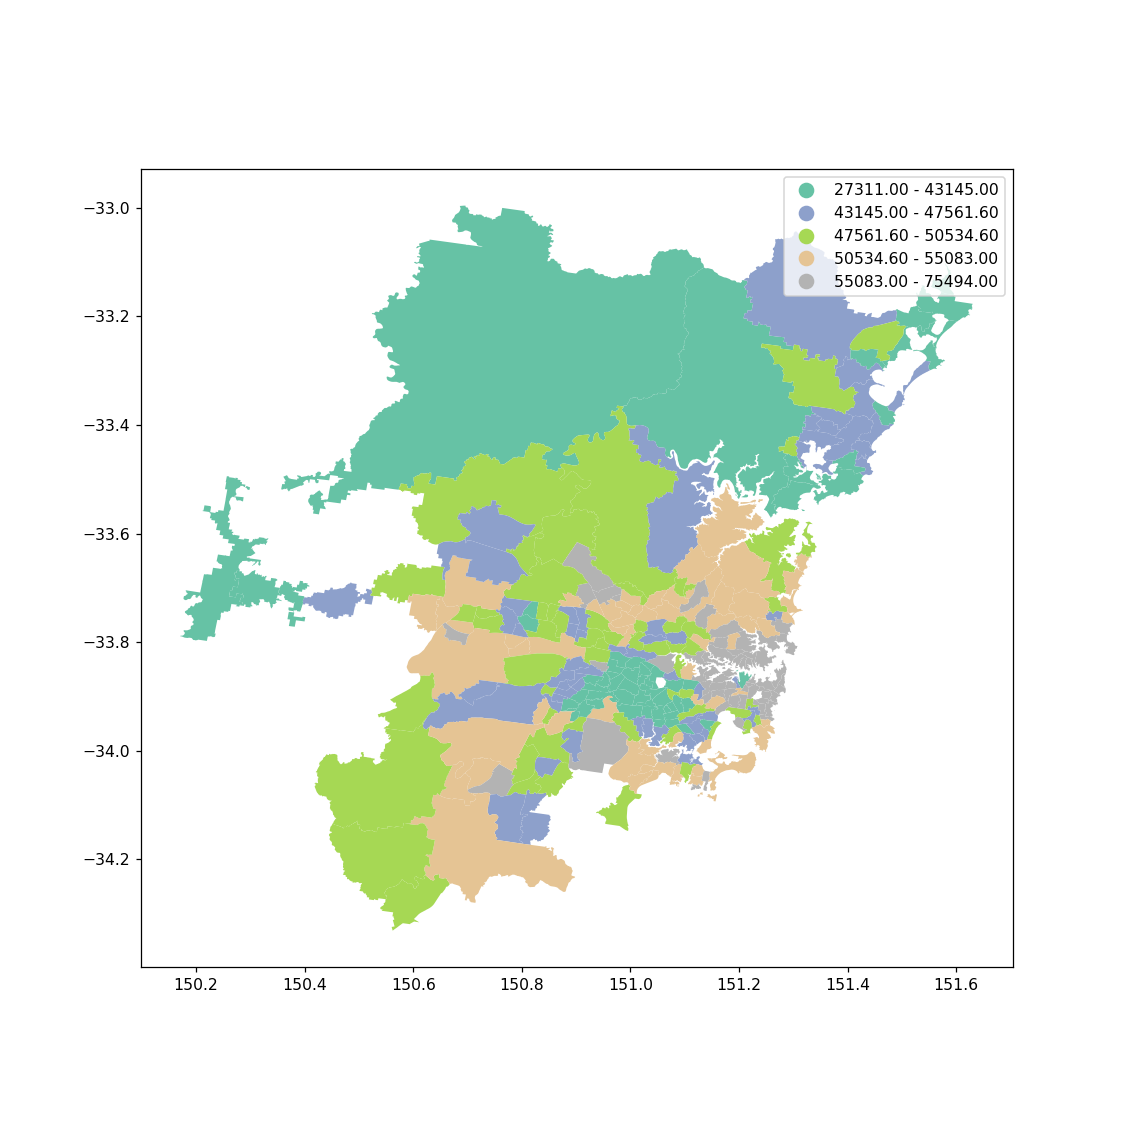

In [594]:
%matplotlib notebook

income_map = gpd.read_postgis("select median_income, geometry as location from geomfinal", conn, geom_col = 'location')
income_map.plot(cmap='Set2',figsize=(10,10), column = 'median_income', scheme='quantiles', legend = True)

#### 3.9.2 Monthly Rent Map visualization

<IPython.core.display.Javascript object>


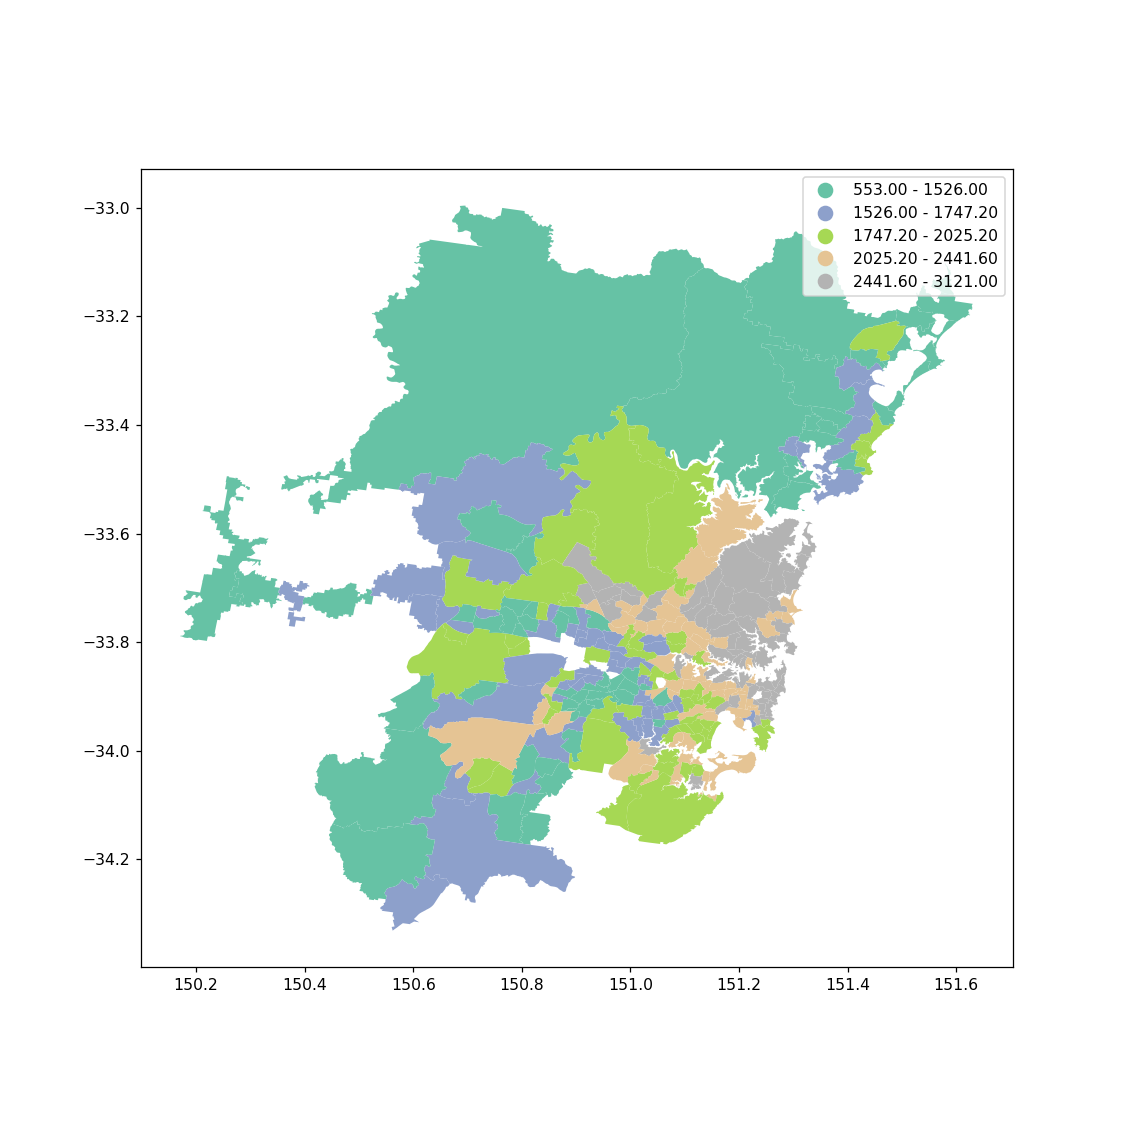

In [595]:
rent_map = gpd.read_postgis("select monthly_rent, geometry as location from geomfinal", conn, geom_col = 'location')
rent_map.plot(cmap='Set2',figsize=(10,10), column = 'monthly_rent', scheme='quantiles', legend = True)

#### 3.9.3 Sigmoid Map visualization

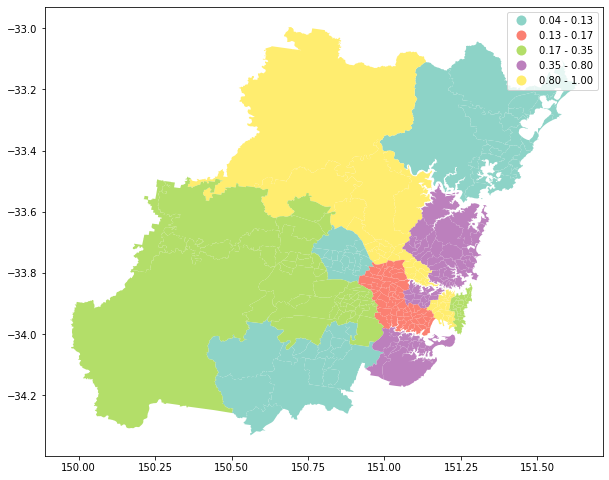

In [19]:
zscore_map = gpd.read_postgis("select sigmoid, geometry as location from geomfinal", conn, geom_col = 'location')
zscore_map.plot(cmap='Set3',figsize=(10,10), column = 'sigmoid', scheme='quantiles', legend = True)

### 3.10 Calculate Correlation Coefficient

#### 3.10.1 Calculate the Correlation Coefficient of median_income and monthly_rent and z_score

In [597]:
corr = mm[["median_income","monthly_rent","sigmoid"]].corr()
corr

,median_income,monthly_rent,sigmoid
median_income,1.000000,0.661919,0.434470
monthly_rent,0.661919,1.000000,0.557529
sigmoid,0.434470,0.557529,1.000000


#### 3.10.2  Correlation Coefficient visualization

<IPython.core.display.Javascript object>


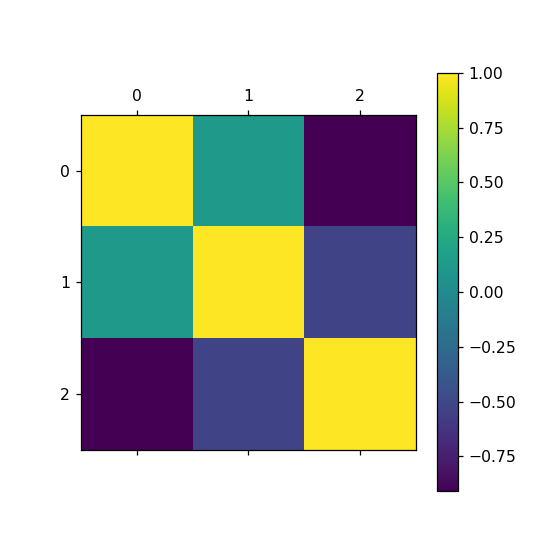

In [598]:
plt.matshow(corr[["median_income","monthly_rent","sigmoid"]].corr())
plt.colorbar()
plt.show()

#### 3.10.3 Visualization of the relationship between Z Score and Median Income

<IPython.core.display.Javascript object>


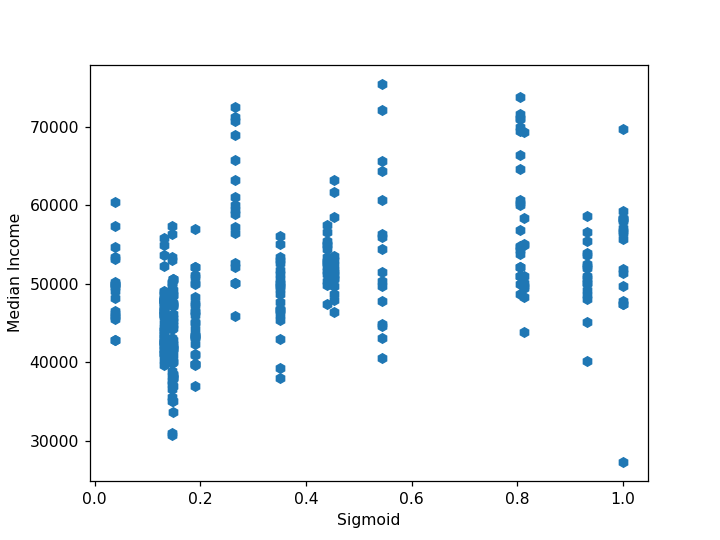

Text(0, 0.5, 'Median Income')

In [599]:
plt.figure()
plt.plot(mm["sigmoid"],mm["median_income"],'h')
plt.xlabel("Sigmoid")
plt.ylabel("Median Income")

#### 3.10.4 Visualization of the relationship between Z Score and Monthly Rent

<IPython.core.display.Javascript object>


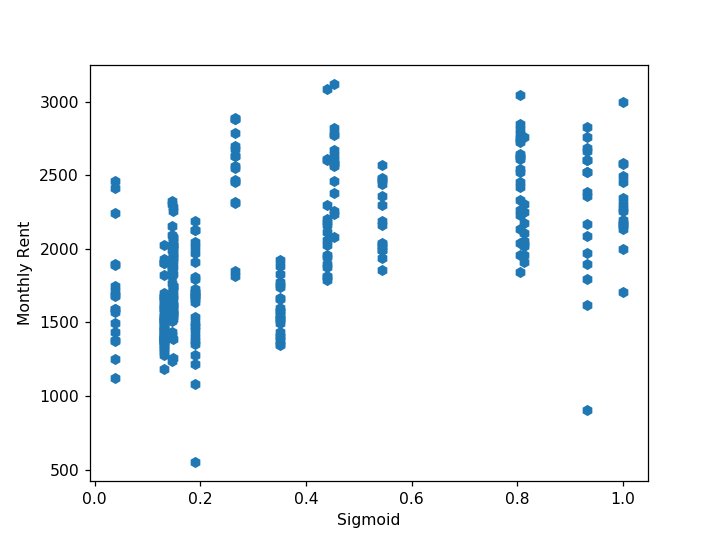

Text(0, 0.5, 'Monthly Rent')

In [600]:
plt.figure()
plt.plot(mm["sigmoid"],mm["monthly_rent"],'h')
plt.xlabel("Sigmoid")
plt.ylabel("Monthly Rent")

## 4. Inner Sydney liveability Analysis

### 4.1 Get the area of inner Sydney

#### 4.1.1 Get the area of inner Sydney through the sa2 file

In [21]:
sql = """
SELECT s."SA2_NAME16" as "Sydney_Inner_City", n."land_area" as "areas", n."population"
FROM sa2 s
join neighbourhoods n
on s."SA2_NAME16" = n."area_name"

where s."SA3_NAME16" = 'Sydney Inner City'


"""
inner_city=query(conn, sql)
inner_city



,Sydney_Inner_City,areas,population
0,Darlinghurst,85.7,12414
1,Erskineville - Alexandria,432.0,17822
2,Glebe - Forest Lodge,230.2,21592
3,Newtown - Camperdown - Darlington,328.1,27450
4,Potts Point - Woolloomooloo,145.9,23809
5,Pyrmont - Ultimo,149.1,24083
6,Redfern - Chippendale,216.3,25538
7,Surry Hills,131.6,18064
8,Sydney - Haymarket - The Rocks,429.3,31010
9,Waterloo - Beaconsfield,358.1,37929


#### 4.1.2 Create a new table inner_city and upload the data to the database

In [22]:
conn.execute("""
DROP TABLE IF EXISTS inner_city;
CREATE TABLE inner_city (
    "Sydney_Inner_City" VARCHAR(50),
    "areas" FLOAT,
    "population" FLOAT
);"""
)

inner_city.to_sql("inner_city", conn, if_exists='append', index=False)
query(conn, "select * from inner_city")

,Sydney_Inner_City,areas,population
0,Darlinghurst,85.7,12414.0
1,Erskineville - Alexandria,432.0,17822.0
2,Glebe - Forest Lodge,230.2,21592.0
3,Newtown - Camperdown - Darlington,328.1,27450.0
4,Potts Point - Woolloomooloo,145.9,23809.0
5,Pyrmont - Ultimo,149.1,24083.0
6,Redfern - Chippendale,216.3,25538.0
7,Surry Hills,131.6,18064.0
8,Sydney - Haymarket - The Rocks,429.3,31010.0
9,Waterloo - Beaconsfield,358.1,37929.0


### 4.2 Wayfinding sign

#### 4.2.1 Get the number of Wayfinding signs in each area of inner Sydney

In [23]:
sql = """
SELECT A."SA2_NAME16" as "Sydney_Inner_City" ,count(*) as "Number of Signs"
FROM sa2 A JOIN signs B ON ST_Intersects(A.geometry, B.geometry)
JOIN inner_city C ON(C."Sydney_Inner_City"= A."SA2_NAME16")
group by A."SA2_NAME16"

"""
ic_signs=query(conn, sql)
ic_signs

,Sydney_Inner_City,Number of Signs
0,Darlinghurst,195
1,Erskineville - Alexandria,186
2,Glebe - Forest Lodge,153
3,Newtown - Camperdown - Darlington,175
4,Potts Point - Woolloomooloo,167
5,Pyrmont - Ultimo,234
6,Redfern - Chippendale,234
7,Surry Hills,172
8,Sydney - Haymarket - The Rocks,952
9,Waterloo - Beaconsfield,221


#### 4.2.2 Create a new table ic_signs and upload the data to the database

In [24]:
conn.execute("""
DROP TABLE IF EXISTS ic_signs;
CREATE TABLE ic_signs (
    "Sydney_Inner_City" VARCHAR(50),
    "Number of Signs" FLOAT
);"""
)

ic_signs.to_sql("ic_signs", conn, if_exists='append', index=False)
query(conn, "select * from ic_signs")

,Sydney_Inner_City,Number of Signs
0,Darlinghurst,195.0
1,Erskineville - Alexandria,186.0
2,Glebe - Forest Lodge,153.0
3,Newtown - Camperdown - Darlington,175.0
4,Potts Point - Woolloomooloo,167.0
5,Pyrmont - Ultimo,234.0
6,Redfern - Chippendale,234.0
7,Surry Hills,172.0
8,Sydney - Haymarket - The Rocks,952.0
9,Waterloo - Beaconsfield,221.0


### 4.3 Crime

#### 4.3.1 Get the Total Hotspot Areas and Total Area and Sum of Hotspot Areas divided by Total Area for each area of inner Sydney

In [25]:
sql = """
SELECT B."SA2_NAME16" as "Sydney_Inner_City" , sum(A."Shape_Area") as "Total Hotspot Areas", avg(D."areas") as "Total Area",
(sum(A."Shape_Area")/avg(D."areas")) as "Sum of Hotspot Areas divided by Total Area"

FROM breakk A JOIN sa2 B ON ST_Intersects(A.geometry, B.geometry)
join total_area C on B."SA4_NAME16" = c."geater_sydney"
join inner_city D on (D."Sydney_Inner_City" = B."SA2_NAME16")
group by B."SA2_NAME16"


"""
ic_crime=query(conn, sql)
ic_crime


,Sydney_Inner_City,Total Hotspot Areas,Total Area,Sum of Hotspot Areas divided by Total Area
0,Darlinghurst,0.005556,85.7,0.000065
1,Erskineville - Alexandria,0.005864,432.0,0.000014
2,Glebe - Forest Lodge,0.005556,230.2,0.000024
3,Newtown - Camperdown - Darlington,0.005712,328.1,0.000017
4,Potts Point - Woolloomooloo,0.005556,145.9,0.000038
5,Pyrmont - Ultimo,0.005557,149.1,0.000037
6,Redfern - Chippendale,0.005712,216.3,0.000026
7,Surry Hills,0.005556,131.6,0.000042
8,Sydney - Haymarket - The Rocks,0.005556,429.3,0.000013
9,Waterloo - Beaconsfield,0.005709,358.1,0.000016


#### 4.3.2 Create a new table ic_crime and upload the obtained data to the database

In [26]:
conn.execute("""
DROP TABLE IF EXISTS ic_crime;
CREATE TABLE ic_crime (
    "Sydney_Inner_City" VARCHAR(50),
    "Total Hotspot Areas" FLOAT,
    "Total Area" FLOAT,
    "Sum of Hotspot Areas divided by Total Area" FLOAT
);"""
)

ic_crime.to_sql("ic_crime", conn, if_exists='append', index=False)
query(conn, "select * from ic_crime")

,Sydney_Inner_City,Total Hotspot Areas,Total Area,Sum of Hotspot Areas divided by Total Area
0,Darlinghurst,0.005556,85.7,0.000065
1,Erskineville - Alexandria,0.005864,432.0,0.000014
2,Glebe - Forest Lodge,0.005556,230.2,0.000024
3,Newtown - Camperdown - Darlington,0.005712,328.1,0.000017
4,Potts Point - Woolloomooloo,0.005556,145.9,0.000038
5,Pyrmont - Ultimo,0.005557,149.1,0.000037
6,Redfern - Chippendale,0.005712,216.3,0.000026
7,Surry Hills,0.005556,131.6,0.000042
8,Sydney - Haymarket - The Rocks,0.005556,429.3,0.000013
9,Waterloo - Beaconsfield,0.005709,358.1,0.000016


### 4.4 Healthcare

#### 4.4.1 Get the number of Healthcare in each area of inner Sydney

In [32]:
sql = """
SELECT A."SA2_NAME16"as "Sydney_Inner_City",
sum(B.health_care_and_social_assistance) as "Num_health",
sum(B.agriculture_forestry_and_fishing) as "Num_forestry",
sum(B.public_administration_and_safety) as "Public_safety"

FROM sa2 A JOIN business B ON (B.area_id=A."SA2_MAIN16")
JOIN inner_city C ON(C."Sydney_Inner_City"= A."SA2_NAME16")
group by A."SA2_NAME16"

"""
ic_health=query(conn, sql)
ic_health

,Sydney_Inner_City,Num_health,Num_forestry,Public_safety
0,Glebe - Forest Lodge,181,11,3
1,Sydney - Haymarket - The Rocks,1217,311,114
2,Surry Hills,206,20,15
3,Redfern - Chippendale,129,3,5
4,Erskineville - Alexandria,112,13,20
5,Pyrmont - Ultimo,167,17,19
6,Newtown - Camperdown - Darlington,360,11,5
7,Potts Point - Woolloomooloo,158,22,6
8,Darlinghurst,280,8,3
9,Waterloo - Beaconsfield,154,10,18


#### 4.4.2 Create a new table ic_health and upload the obtained data to the database

In [33]:
conn.execute("""
DROP TABLE IF EXISTS ic_health;
CREATE TABLE ic_health (
    "Sydney_Inner_City" VARCHAR(50),
    "Num_health" FLOAT,
    "Num_forestry" FLOAT,
    "Public_safety" FLOAT

);"""
)

ic_health.to_sql("ic_health", conn, if_exists='append', index=False)
query(conn, "select * from ic_health")

,Sydney_Inner_City,Num_health,Num_forestry,Public_safety
0,Glebe - Forest Lodge,181.0,11.0,3.0
1,Sydney - Haymarket - The Rocks,1217.0,311.0,114.0
2,Surry Hills,206.0,20.0,15.0
3,Redfern - Chippendale,129.0,3.0,5.0
4,Erskineville - Alexandria,112.0,13.0,20.0
5,Pyrmont - Ultimo,167.0,17.0,19.0
6,Newtown - Camperdown - Darlington,360.0,11.0,5.0
7,Potts Point - Woolloomooloo,158.0,22.0,6.0
8,Darlinghurst,280.0,8.0,3.0
9,Waterloo - Beaconsfield,154.0,10.0,18.0


### 4.5 Gardens

#### 4.5.1 Get the number of Gardens in each area of inner Sydney

In [29]:
sql = """
SELECT A."SA2_NAME16"as "Sydney_Inner_City",count(*) as "Number of Gardens"
FROM sa2 A JOIN garden B ON ST_Intersects(A.geometry, B.geometry)
JOIN inner_city C ON(C."Sydney_Inner_City"= A."SA2_NAME16")
group by A."SA2_NAME16"

"""
ic_garden=query(conn, sql)
ic_garden

,Sydney_Inner_City,Number of Gardens
0,Darlinghurst,6
1,Erskineville - Alexandria,8
2,Glebe - Forest Lodge,19
3,Newtown - Camperdown - Darlington,6
4,Potts Point - Woolloomooloo,19
5,Pyrmont - Ultimo,21
6,Redfern - Chippendale,51
7,Surry Hills,9
8,Sydney - Haymarket - The Rocks,6
9,Waterloo - Beaconsfield,84


#### 4.5.2 Create a new table ic_garden and upload the data to the database

In [30]:
conn.execute("""
DROP TABLE IF EXISTS ic_garden;
CREATE TABLE ic_garden (
    "Sydney_Inner_City" VARCHAR(50),
    "Number of Gardens" FLOAT
);"""
)

ic_garden.to_sql("ic_garden", conn, if_exists='append', index=False)
query(conn, "select * from ic_garden")

,Sydney_Inner_City,Number of Gardens
0,Darlinghurst,6.0
1,Erskineville - Alexandria,8.0
2,Glebe - Forest Lodge,19.0
3,Newtown - Camperdown - Darlington,6.0
4,Potts Point - Woolloomooloo,19.0
5,Pyrmont - Ultimo,21.0
6,Redfern - Chippendale,51.0
7,Surry Hills,9.0
8,Sydney - Haymarket - The Rocks,6.0
9,Waterloo - Beaconsfield,84.0


### 4.6 Integrate all data from Part IV

#### 4.6.1 Integrate all the fourth section data and calculate their average

In [34]:
sql = """
SELECT A."Sydney_Inner_City",
(A."Sum of Hotspot Areas divided by Total Area") as "crime",
(B."Number of Signs"/i."population") as "avg_signs",
(C."Num_health"/i."population") as "avg_health",
(C."Num_forestry"/i."population") as "avg_forestry",
(C."Public_safety"/i."population") as "avg_safety",
(D."Number of Gardens"/i."population") as "avg_gardens"

FROM ic_health C JOIN ic_signs B using("Sydney_Inner_City")
join inner_city i using("Sydney_Inner_City")
JOIN ic_crime A using("Sydney_Inner_City")
JOIN ic_garden D using("Sydney_Inner_City")

"""


sql = pd.read_sql_query(sql, conn)

sql['sum_z_score'] = (stats.zscore(sql['avg_signs']) + 
                              stats.zscore(sql['avg_health']) + 
                              stats.zscore(sql['avg_forestry']) + 
                              stats.zscore(sql['avg_safety']) + 
                              stats.zscore(sql['avg_gardens']) - 
                              stats.zscore(sql['crime']))

sql['sigmoid'] = logistic.cdf(stats.zscore(sql['avg_signs']) + 
                              stats.zscore(sql['avg_health']) + 
                              stats.zscore(sql['avg_forestry']) + 
                              stats.zscore(sql['avg_safety']) + 
                              stats.zscore(sql['avg_gardens']) - 
                              stats.zscore(sql['crime']))

sql

,Sydney_Inner_City,crime,avg_signs,avg_health,avg_forestry,avg_safety,avg_gardens,sum_z_score,sigmoid
0,Darlinghurst,0.000065,0.015708,0.022555,0.000644,0.000242,0.000483,-2.066887,0.112357
1,Erskineville - Alexandria,0.000014,0.010437,0.006284,0.000729,0.001122,0.000449,-0.262703,0.434699
2,Glebe - Forest Lodge,0.000024,0.007086,0.008383,0.000509,0.000139,0.000880,-1.610537,0.166514
3,Newtown - Camperdown - Darlington,0.000017,0.006375,0.013115,0.000401,0.000182,0.000219,-1.811594,0.140446
4,Potts Point - Woolloomooloo,0.000038,0.007014,0.006636,0.000924,0.000252,0.000798,-2.548476,0.072529
5,Pyrmont - Ultimo,0.000037,0.009716,0.006934,0.000706,0.000789,0.000872,-1.520221,0.179429
6,Redfern - Chippendale,0.000026,0.009163,0.005051,0.000117,0.000196,0.001997,-0.187498,0.453262
7,Surry Hills,0.000042,0.009522,0.011404,0.001107,0.000830,0.000498,-1.811283,0.140483
8,Sydney - Haymarket - The Rocks,0.000013,0.030700,0.039245,0.010029,0.003676,0.000193,11.252616,0.999987
9,Waterloo - Beaconsfield,0.000016,0.005827,0.004060,0.000264,0.000475,0.002215,0.566582,0.637974


#### 4.6.2 Create a new table ic_final and upload the obtained data to the database

In [35]:
conn.execute("""
DROP TABLE IF EXISTS ic_final;
CREATE TABLE ic_final (
    "Sydney_Inner_City" VARCHAR(50),
    "crime" FLOAT,
    "avg_signs" FLOAT,
    "avg_health" FLOAT,
    "avg_forestry" FLOAT,
    "avg_safety" FLOAT,
    "avg_gardens" FLOAT,
    "sum_z_score" FLOAT,
    "sigmoid" FLOAT
);"""
)

sql.to_sql("ic_final", conn, if_exists='append', index=False)
query(conn, "select * from ic_final")

,Sydney_Inner_City,crime,avg_signs,avg_health,avg_forestry,avg_safety,avg_gardens,sum_z_score,sigmoid
0,Darlinghurst,0.000065,0.015708,0.022555,0.000644,0.000242,0.000483,-2.066887,0.112357
1,Erskineville - Alexandria,0.000014,0.010437,0.006284,0.000729,0.001122,0.000449,-0.262703,0.434699
2,Glebe - Forest Lodge,0.000024,0.007086,0.008383,0.000509,0.000139,0.000880,-1.610537,0.166514
3,Newtown - Camperdown - Darlington,0.000017,0.006375,0.013115,0.000401,0.000182,0.000219,-1.811594,0.140446
4,Potts Point - Woolloomooloo,0.000038,0.007014,0.006636,0.000924,0.000252,0.000798,-2.548476,0.072529
5,Pyrmont - Ultimo,0.000037,0.009716,0.006934,0.000706,0.000789,0.000872,-1.520221,0.179429
6,Redfern - Chippendale,0.000026,0.009163,0.005051,0.000117,0.000196,0.001997,-0.187498,0.453262
7,Surry Hills,0.000042,0.009522,0.011404,0.001107,0.000830,0.000498,-1.811283,0.140483
8,Sydney - Haymarket - The Rocks,0.000013,0.030700,0.039245,0.010029,0.003676,0.000193,11.252616,0.999987
9,Waterloo - Beaconsfield,0.000016,0.005827,0.004060,0.000264,0.000475,0.002215,0.566582,0.637974


#### 4.6.3 Join ic_final to sa2 to find the geom data, and marge them.

In [13]:
geomicfinal = """
SELECT 

s."SA2_NAME16" as name1,

s."SA3_NAME16" as name2,

s."SA4_NAME16" as name3,

s."GCC_NAME16" as name4,

s."geometry", 

f."avg_signs",

f."avg_health",

f."avg_forestry",

f."avg_safety",

f."avg_gardens",

n."median_annual_household_income" as median_income ,

n."avg_monthly_rent" as monthly_rent,

f."sum_z_score",

f."sigmoid"


FROM sa2 s
join ic_final f on s."SA2_NAME16"= f."Sydney_Inner_City"
join neighbourhoods n 
on s."SA2_MAIN16"  = n."area_id"
"""
po = pd.read_sql_query(geomicfinal,conn)
po

,name1,name2,name3,name4,geometry,avg_signs,avg_health,avg_forestry,avg_safety,avg_gardens,median_income,monthly_rent,sum_z_score,sigmoid
0,Darlinghurst,Sydney Inner City,Sydney - City and Inner South,Greater Sydney,0106000020BB10000001000000010300000001000000A8...,0.015708,0.022555,0.000644,0.000242,0.000483,59293,2491,-2.066887,0.112357
1,Erskineville - Alexandria,Sydney Inner City,Sydney - City and Inner South,Greater Sydney,0106000020BB100000010000000103000000010000000A...,0.010437,0.006284,0.000729,0.001122,0.000449,69680,2581,-0.262703,0.434699
2,Glebe - Forest Lodge,Sydney Inner City,Sydney - City and Inner South,Greater Sydney,0106000020BB1000000100000001030000000100000008...,0.007086,0.008383,0.000509,0.000139,0.000880,56691,2162,-1.610537,0.166514
3,Newtown - Camperdown - Darlington,Sydney Inner City,Sydney - City and Inner South,Greater Sydney,0106000020BB1000000100000001030000000100000014...,0.006375,0.013115,0.000401,0.000182,0.000219,58210,2270,-1.811594,0.140446
4,Potts Point - Woolloomooloo,Sydney Inner City,Sydney - City and Inner South,Greater Sydney,0106000020BB10000001000000010300000001000000B1...,0.007014,0.006636,0.000924,0.000252,0.000798,58253,2256,-2.548476,0.072529
5,Pyrmont - Ultimo,Sydney Inner City,Sydney - City and Inner South,Greater Sydney,0106000020BB1000000100000001030000000100000027...,0.009716,0.006934,0.000706,0.000789,0.000872,47393,2575,-1.520221,0.179429
6,Redfern - Chippendale,Sydney Inner City,Sydney - City and Inner South,Greater Sydney,0106000020BB100000010000000103000000010000003F...,0.009163,0.005051,0.000117,0.000196,0.001997,51347,2193,-0.187498,0.453262
7,Surry Hills,Sydney Inner City,Sydney - City and Inner South,Greater Sydney,0106000020BB10000001000000010300000001000000A2...,0.009522,0.011404,0.001107,0.000830,0.000498,58396,2342,-1.811283,0.140483
8,Sydney - Haymarket - The Rocks,Sydney Inner City,Sydney - City and Inner South,Greater Sydney,0106000020BB100000030000000103000000010000000E...,0.030700,0.039245,0.010029,0.003676,0.000193,27311,2998,11.252616,0.999987
9,Waterloo - Beaconsfield,Sydney Inner City,Sydney - City and Inner South,Greater Sydney,0106000020BB10000001000000010300000001000000F7...,0.005827,0.004060,0.000264,0.000475,0.002215,57055,2302,0.566582,0.637974


#### 4.6.4 Create a new table geomic data to store the data

In [15]:
conn.execute("""
DROP TABLE IF EXISTS geomicfinal;
CREATE TABLE geomicfinal (
    "name1" VARCHAR(80),
    "name2" VARCHAR(80),
    "name3" VARCHAR(80),
    "name4" VARCHAR(80),
    "geometry" GEOMETRY(MULTIPOLYGON,4283),
    "avg_signs" FLOAT,
    "avg_health" FLOAT,
    "avg_forestry" FLOAT,
    "avg_safety" FLOAT,
    "avg_gardens" FLOAT,
    "median_income" FLOAT,
    "monthly_rent" FLOAT,
    "sum_z_score" FLOAT,
    "sigmoid" FLOAT
);"""
)

po.to_sql("geomicfinal", conn, if_exists='append', index=False)
query(conn, "select * from geomicfinal")

,name1,name2,name3,name4,geometry,avg_signs,avg_health,avg_forestry,avg_safety,avg_gardens,median_income,monthly_rent,sum_z_score,sigmoid
0,Darlinghurst,Sydney Inner City,Sydney - City and Inner South,Greater Sydney,0106000020BB10000001000000010300000001000000A8...,0.015708,0.022555,0.000644,0.000242,0.000483,59293.0,2491.0,-2.066887,0.112357
1,Erskineville - Alexandria,Sydney Inner City,Sydney - City and Inner South,Greater Sydney,0106000020BB100000010000000103000000010000000A...,0.010437,0.006284,0.000729,0.001122,0.000449,69680.0,2581.0,-0.262703,0.434699
2,Sydney - Haymarket - The Rocks,Sydney Inner City,Sydney - City and Inner South,Greater Sydney,0106000020BB100000030000000103000000010000000E...,0.030700,0.039245,0.010029,0.003676,0.000193,27311.0,2998.0,11.252616,0.999987
3,Glebe - Forest Lodge,Sydney Inner City,Sydney - City and Inner South,Greater Sydney,0106000020BB1000000100000001030000000100000008...,0.007086,0.008383,0.000509,0.000139,0.000880,56691.0,2162.0,-1.610537,0.166514
4,Newtown - Camperdown - Darlington,Sydney Inner City,Sydney - City and Inner South,Greater Sydney,0106000020BB1000000100000001030000000100000014...,0.006375,0.013115,0.000401,0.000182,0.000219,58210.0,2270.0,-1.811594,0.140446
5,Potts Point - Woolloomooloo,Sydney Inner City,Sydney - City and Inner South,Greater Sydney,0106000020BB10000001000000010300000001000000B1...,0.007014,0.006636,0.000924,0.000252,0.000798,58253.0,2256.0,-2.548476,0.072529
6,Pyrmont - Ultimo,Sydney Inner City,Sydney - City and Inner South,Greater Sydney,0106000020BB1000000100000001030000000100000027...,0.009716,0.006934,0.000706,0.000789,0.000872,47393.0,2575.0,-1.520221,0.179429
7,Redfern - Chippendale,Sydney Inner City,Sydney - City and Inner South,Greater Sydney,0106000020BB100000010000000103000000010000003F...,0.009163,0.005051,0.000117,0.000196,0.001997,51347.0,2193.0,-0.187498,0.453262
8,Surry Hills,Sydney Inner City,Sydney - City and Inner South,Greater Sydney,0106000020BB10000001000000010300000001000000A2...,0.009522,0.011404,0.001107,0.000830,0.000498,58396.0,2342.0,-1.811283,0.140483
9,Waterloo - Beaconsfield,Sydney Inner City,Sydney - City and Inner South,Greater Sydney,0106000020BB10000001000000010300000001000000F7...,0.005827,0.004060,0.000264,0.000475,0.002215,57055.0,2302.0,0.566582,0.637974


### 4.7 Visualize data

#### 4.7.1 Median Income Map visualization

<IPython.core.display.Javascript object>


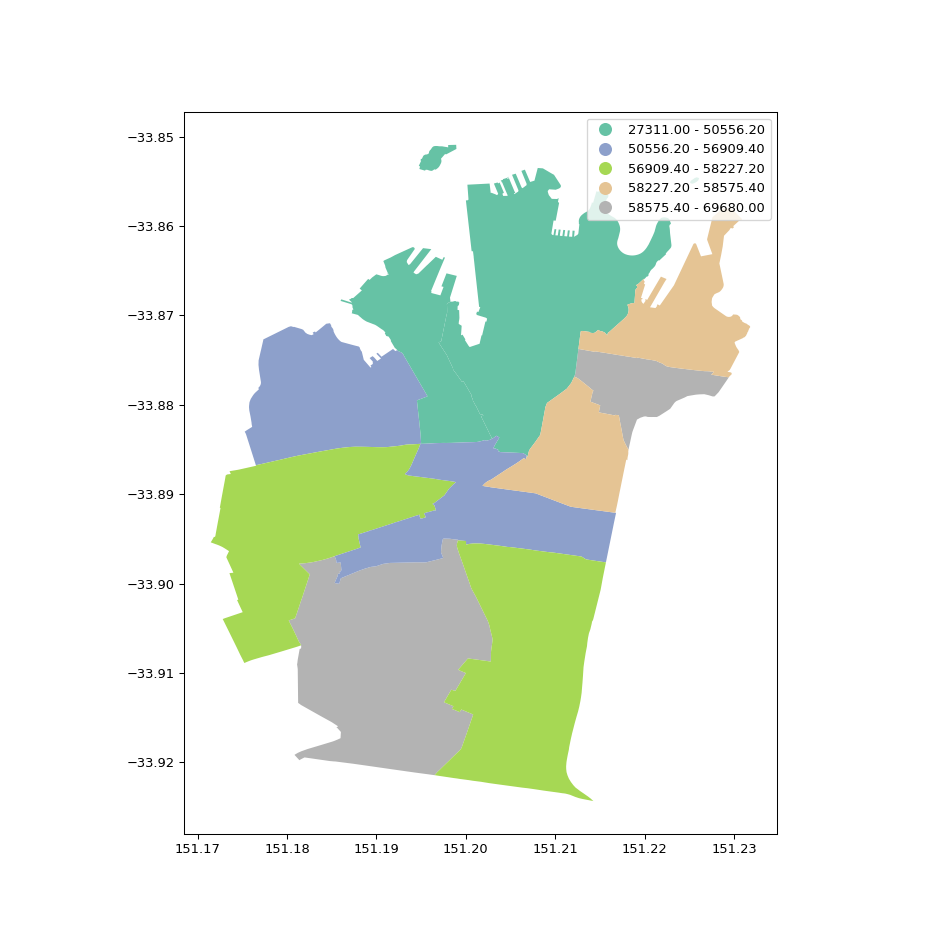

In [16]:
%matplotlib notebook

income_map = gpd.read_postgis("select median_income, geometry as location from geomicfinal", conn, geom_col = 'location')
income_map.plot(cmap='Set2',figsize=(10,10), column = 'median_income', scheme='quantiles', legend = True)

#### 4.7.2 Monthly Rent Map visualization


<IPython.core.display.Javascript object>


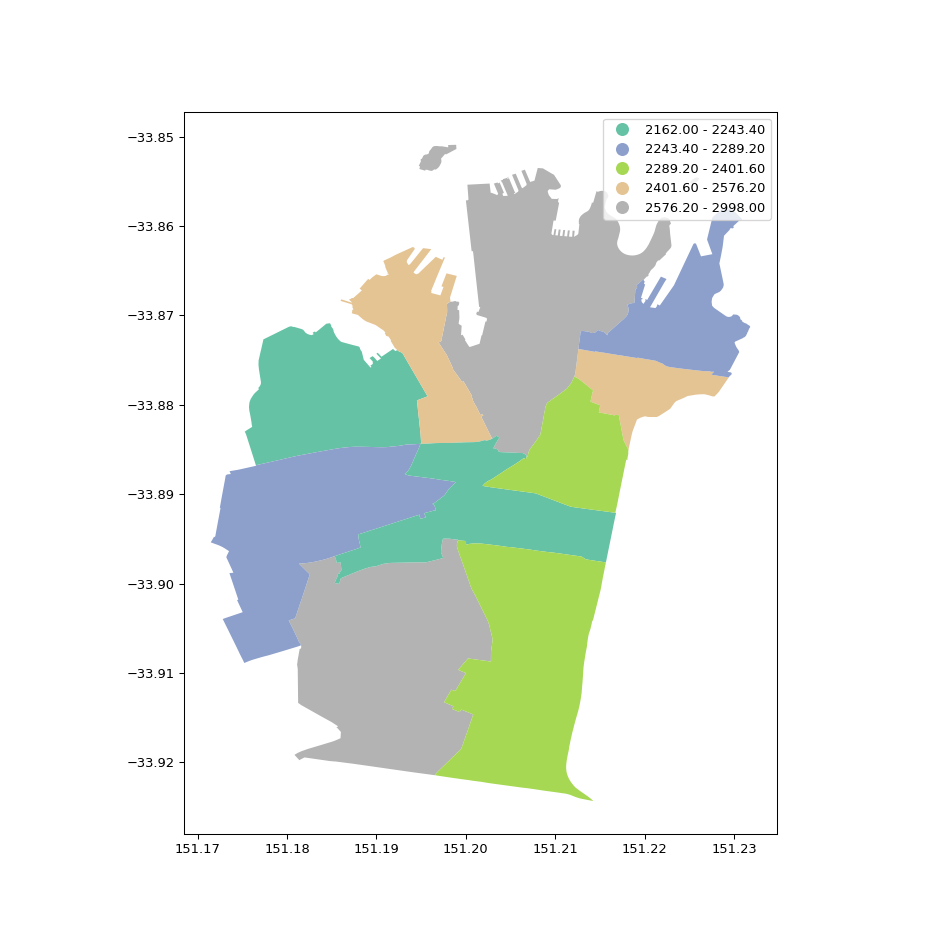

In [17]:
rent_map = gpd.read_postgis("select monthly_rent, geometry as location from geomicfinal", conn, geom_col = 'location')
rent_map.plot(cmap='Set2',figsize=(10,10), column = 'monthly_rent', scheme='quantiles', legend = True)

#### 4.7.3 Sigmoid Map visualization

<IPython.core.display.Javascript object>


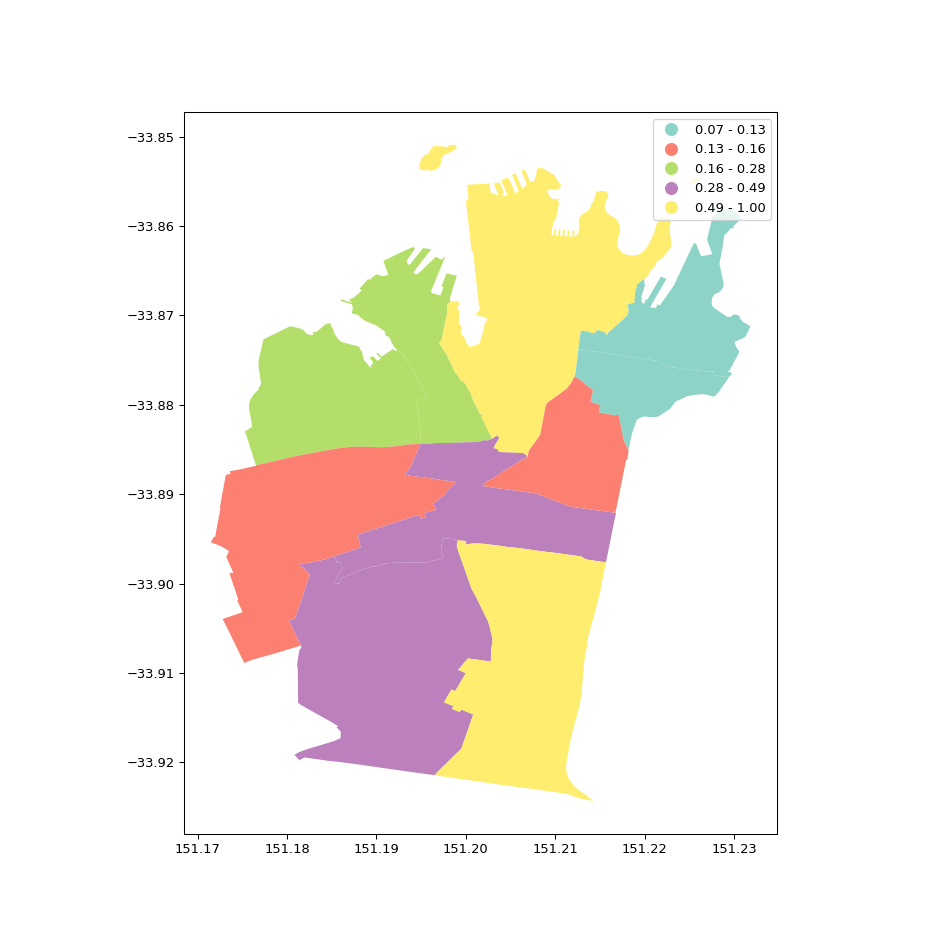

In [18]:
zscore_map = gpd.read_postgis("select sigmoid, geometry as location from geomicfinal", conn, geom_col = 'location')
zscore_map.plot(cmap='Set3',figsize=(10,10), column = 'sigmoid', scheme='quantiles', legend = True)

### 4.8 Calculate Correlation Coefficient

In [23]:
corr = po[["monthly_rent","sigmoid"]].corr()
corr

,monthly_rent,sigmoid
monthly_rent,1.000000,0.629489
sigmoid,0.629489,1.000000


### 4.9 Correlation Coefficient visualization

<IPython.core.display.Javascript object>


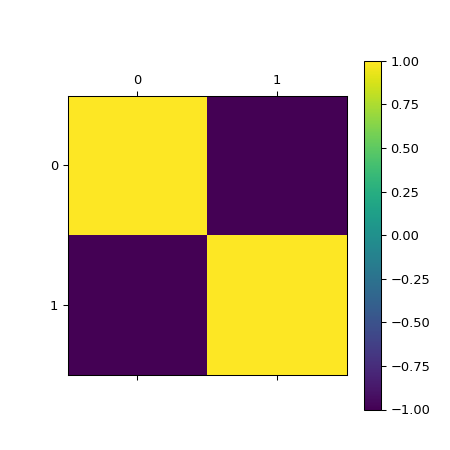

In [25]:
plt.matshow(corr[["monthly_rent","sigmoid"]].corr())
plt.colorbar()
plt.show()

### 4.10 Visualization of the relationship between Z Score and Monthly Rent

<IPython.core.display.Javascript object>


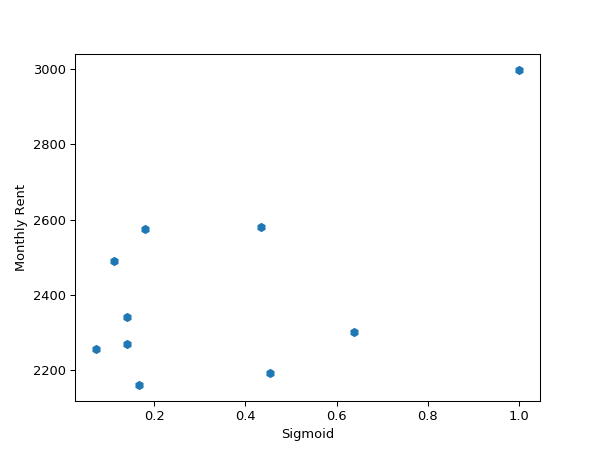

Text(0, 0.5, 'Monthly Rent')

In [26]:
plt.figure()
plt.plot(po["sigmoid"],po["monthly_rent"],'h')
plt.xlabel("Sigmoid")
plt.ylabel("Monthly Rent")
